In [200]:
import pandas as pd
import AnalFunctions as af
import numpy as np
import matplotlib.pyplot as plt
import os
import math as m
import seaborn as sns

path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var, test_var2, test_str2, lin_var, T_test_list, sec_test_var, N_ped, fps, mot_frac = af.var_ini()
af.file_writer(path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var)

sl = "/"
T_test_list = lin_var[test_var2]
lattice_type = 'jule'
runs_tested = N_runs
traj_testvar2 = []


def dist(x1, y1, x2, y2, x3, y3): # x3,y3 is the point

    px = x2-x1
    py = y2-y1

    norm = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)

    #u_new = np.array([1 if ui > 1 else 0 for ui in u])
    u[u > 1] = 1
    u[u < 0] = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    # Note: If the actual distance does not matter,
    # if you only want to compare what this function
    # returns to other results of this function, you
    # can just return the squared distance instead
    # (i.e. remove the sqrt) to gain a little performance

    dist = np.sqrt(dx*dx + dy*dy)
    return dist



current path is  trajectories/ini_lm_N_ped55_tmax308_size_0_17_fps_16_testvar_b/
Index(['Unnamed: 0', 'ini_folder', 'b', 'v0', 'T', 'rho', 'esigma', 'N_ped'], dtype='object')
0      1.3
1      0.1
2      1.3
3      0.1
4      1.3
      ... 
115    0.1
116    1.3
117    0.1
118    1.3
119    0.1
Name: T, Length: 120, dtype: float64
[1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1
 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1
 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1
 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1
 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1
 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1
 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1]
[[ 0.7   0.55  1.34  1.3   2.5  55.    0.25]
 [ 0.7   0.55  1.34  0.1   2.5  55.    0.25]
 [ 0.7   0.6   1.34  1.3   2.5  55.    0.25]
 [ 0.7   0.6   1.34  0.1   2.5  55.    0.25]

/writing files


In [201]:
from scipy.spatial import Delaunay
import CorFunFast as cff

def find_neighbors(pindex, triang):
    return triang.vertex_neighbor_vertices[1][triang.vertex_neighbor_vertices[0][pindex]:triang.vertex_neighbor_vertices[0][pindex+1]]

def indexDistance(p_index,tri):
    neigh = find_neighbors(p_index,tri)
    dist_list = np.empty(neigh.shape[0])
    for n in range(neigh.shape[0]):
        bond = tri.points[neigh[n]] - tri.points[p_index]
        dist = np.linalg.norm(bond)
        dist_list[n] = dist
    return dist_list
    
def localBondOrientationFactor(p_index,tri):
    neigh = find_neighbors(p_index,tri)
    Nb = neigh.shape[0]
    bond_orientation_list = np.empty(Nb)
    cos_sum = 0
    for n in range(Nb -1):
        bond1 = tri.points[neigh[n]] - tri.points[p_index]
        bond2 = tri.points[neigh[n+1]] - tri.points[p_index]
        leng1 = np.linalg.norm(bond1)
        leng2 = np.linalg.norm(bond2)
        bond1 = bond1/leng1
        bond2 = bond2/leng2
        #print(round(np.dot(bond1,bond2),4))
        #print(np.dot(bond1,bond2) - pi/6)
        bond_angle = np.cos(6 * np.arccos(round(np.dot(bond1,bond2),4)))
        cos_sum += bond_angle
    nb_sum = 1/(Nb -1) * cos_sum

    return nb_sum

def bondOrientationFactor(tri,N):
    nb_sum = 0
    for p_index in range(N):
            #print(tri.points[p_index])
        neigh = find_neighbors(p_index,tri)
        Nb = len(neigh)
        cos_sum = 0
        for n in range(Nb-1):
            bond1 = tri.points[neigh[n]] - tri.points[p_index]
            bond2 = tri.points[neigh[n+1]] - tri.points[p_index]
            leng1 = np.dot(bond1,bond1)
            leng2 = np.dot(bond2,bond2)
            bond1 = bond1/np.sqrt(leng1)
            bond2 = bond2/np.sqrt(leng2)
            #print(round(np.dot(bond1,bond2),4))
            bond_angle = np.cos(6 * np.arccos(round(np.dot(bond1,bond2),4)))
            #bond_angle = round(np.dot(bond1,bond2),4)

            #print(bond_angle)
            cos_sum += bond_angle
        nb_sum += 1/(Nb -1) * cos_sum

    return 1/N * nb_sum

def hexagonalLattice(N_in,a,mu,lb,hb,N):
    # (N_in/a)**2 is the number of points
    #a is point distance
    #mu is noise level
    #lb and hb are the bounds of the uniform distribution
    #N is the number of hexagonal lattices that are produced and written into a N X N_in^2/a^2 dimensional array
    l_x = np.empty([N,int(N_in * N_in/a**2)])
    l_y = np.empty([N,int(N_in * N_in/a**2)])

    for i in range(N):
        h_list = np.arange(0,N_in,a)
        l_list = np.arange(0,N_in,a)
        x = np.array([(h/2 - 1/2 * l) for h in h_list for l in l_list])
        y = np.array([(m.sqrt(3)/2 * h + m.sqrt(3)/2 * l) for h in h_list for l in l_list])
        x_noise = mu * np.random.uniform(lb,hb ,x.shape[0])
        y_noise = mu * np.random.uniform(lb,hb,y.shape[0])
        x = x + x_noise
        y = y + y_noise
        l_x[i] = x
        l_y[i] = y
    
    return l_x,l_y

def latticeDistance(tri):
    points[tri.simplices]
    dist = []
    dist_tri = []
    for t in points[tri.simplices]:
        d1 = t[0] - t[1]
        d2 = t[0] - t[2]
        d3 = t[1] - t[2]
        d1 = np.linalg.norm(d1)
        d2 = np.linalg.norm(d2)
        d3 = np.linalg.norm(d3)

        dist.append(d1)
        dist.append(d2)
        dist.append(d3)
        dist_tri.append([d1,d2,d3])
    return dist_tri, dist
def delHexMeasure(dist_tri,dist):
    dist_mean = dist.mean()
    del_m = dist_tri - dist_mean
    del_m = np.abs(del_m)
    del_m = np.sum(del_m,axis = 1)
    del_m = del_m.mean()
    return del_m

def normal(lattice_x, lattice_y, x_array, y_array, a):
    x_dens = np.array(
        [lattice_x - x for x in x_array])  # calculate the distant of lattice pedestrians to the measuring lattice
    y_dens = np.array([lattice_y - y for y in y_array])

    rho_matrix_x = np.array([densty1d(delta_x, a) for delta_x in x_dens])  # density matrix is calculated
    rho_matrix_y = np.array([densty1d(delta_y, a) for delta_y in y_dens])
    rho_matrix = np.matmul(rho_matrix_x, np.transpose(rho_matrix_y))
    return rho_matrix.T

def densty1d(delta_x, a):
    return np.array(list(map(lambda x: 1 / (m.sqrt(m.pi) * a) * m.e ** (-x ** 2 / a ** 2), delta_x)))
def densty1dWeight(delta_x, weight,a):
    return np.array(list(map(lambda var: np.sqrt(abs(var[1])) / (m.sqrt(m.pi) * a) * m.e ** (-var[0] ** 2 / a ** 2), zip(delta_x,weight))))

def densty1dWeightSign(delta_x, weight,a):
    return np.array(list(map(lambda var: np.sqrt(var[1]) / (m.sqrt(m.pi) * a) * m.e ** (-var[0] ** 2 / a ** 2) if var[1] > 0 else -np.sqrt(abs(var[1])) / (m.sqrt(m.pi) * a) * m.e ** (-var[0] ** 2 / a ** 2), zip(delta_x,weight) )))

def orderField(lattice_x,lattice_y,order,x_array,y_array,a):
    x_dens = np.array([lattice_x - x for x in x_array])  # calculate the distant of lattice pedestrians to the measuring lattice
    y_dens = np.array([lattice_y - y for y in y_array])

    rho_matrix_x = np.array([densty1dWeightSign(delta_x,order, a) for delta_x in x_dens])  # density matrix is calculated
    rho_matrix_y = np.array([densty1dWeight(delta_y,order, a) for delta_y in y_dens])
    rho_matrix = np.matmul(rho_matrix_x, np.transpose(rho_matrix_y))
    order_matrix = rho_matrix.T/normal(lattice_x, lattice_y, x_array, y_array, a)
    
    return order_matrix
    

def localOrientationMeasures(tri,N):
    neighbour_list = np.empty(N)
    neigh_dist_list = np.empty(N)
    local_bond_list = np.empty(N)
    for p_index in range(N):
        neigh_dist = indexDistance(p_index,tri)
        neighbour_list[p_index] = len(find_neighbors(p_index,tri))
        neigh_dist_list[p_index] = neigh_dist.var()/neigh_dist.mean()**2
        local_bond_list[p_index] = localBondOrientationFactor(p_index,tri)
    return neighbour_list, neigh_dist_list, local_bond_list
    
def pedReducer(XY,x_min,x_max,y_min,y_max,Nn_max):
    XY_red = XY[XY['Nn'] < Nn_max]
    XY_red = XY[XY['x'] < x_max]
    XY_red = XY_red[XY_red['x'] > x_min]
    XY_red = XY_red[XY_red['y'] < y_max]
    XY_red = XY_red[XY_red['y'] > y_min]
    return XY_red
    
    

In [166]:
sl = "/"
print("writing files")
folder_anal_frame = [np.array(folder_frame[(folder_frame[test_str] == var[test_var])]['ini_folder'])[0] for var in
                     cross_var]
for i in range(N_runs):
    location = np.array(
        ["new_evac_traj_" + af.b_data_name(2 * b[var], 3) + "_" + str(i) + ".txt" for var in range(cross_var.shape[0])])
    seg_location = np.array(
        ["evac_traj_" + af.b_data_name(2 * b[var], 3) + "_" + str(i) for var in range(cross_var.shape[0])])
    for loc, run_folder, segloc in zip(location, folder_list,seg_location):

        file_name = path + run_folder + sl + loc
        if os.path.isfile(file_name):
            file = open(file_name, 'r')
            line_count = 0
            new_file_name = path + run_folder + sl + "stitch_" + loc
            if os.path.isfile(new_file_name) == False:
                new_file = open(new_file_name, 'w')

                for line in file:
                    new_file.write(line)
                string = "_000"
                segment = np.arange(1,10)
                for seg in segment:
                    segnumber = string + str(seg)
                    segfile = path + run_folder + sl + segloc + segnumber + ".txt"
                    #print(segfile)
                    if os.path.isfile(segfile):
                        stichfile = open(segfile,"r")
                        line_count = 1
                        for line in stichfile:
                            if line_count > 13:
                                new_file.write(line)
                            line_count += 1
                        os.system("rm " + segfile)
                    else:
                        print("!!!!!!!!there is no " + segfile + "!!!!!!!!")
                        break

                new_file.close()
                
        else:
            print("WARNING: file " + file_name + " not found")

    


writing files


<calculating b = 1.1>


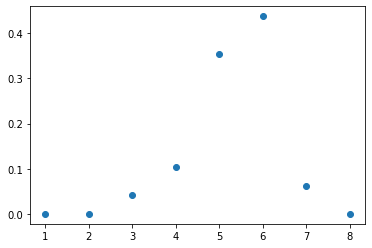

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.09303865670490183
del measure =  0.60146511627907
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


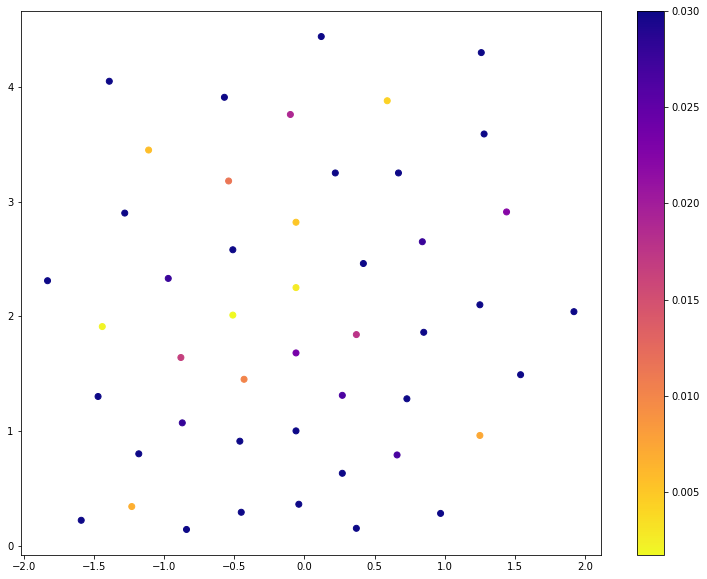

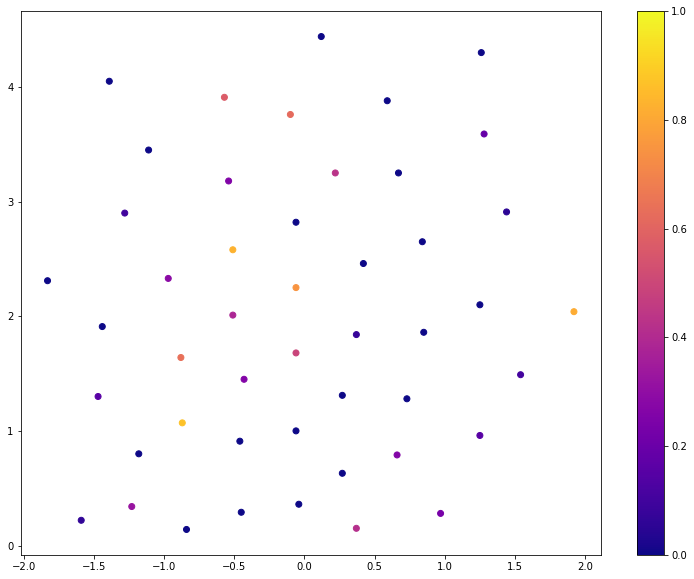

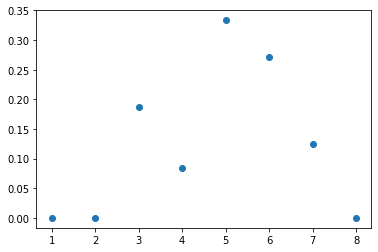

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.09745943902296168
del measure =  0.49036111111111114
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


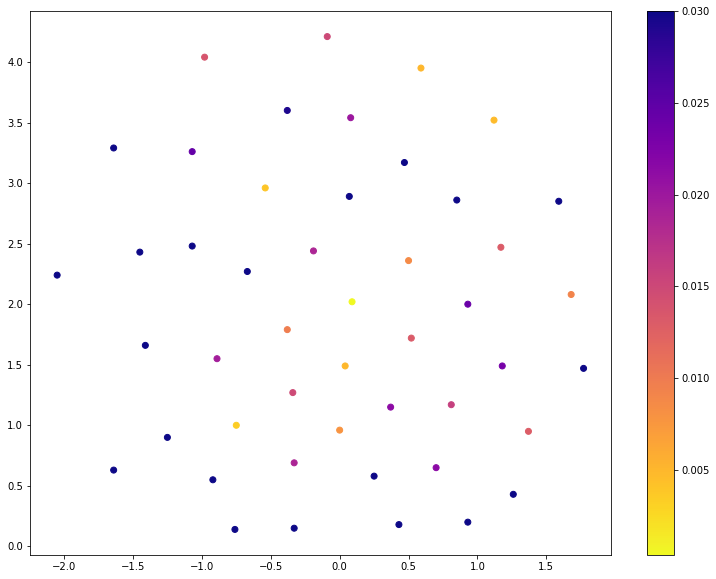

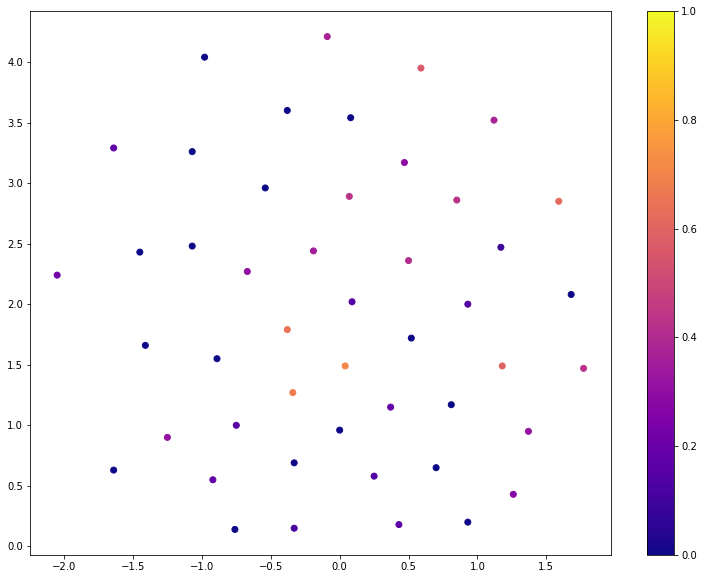

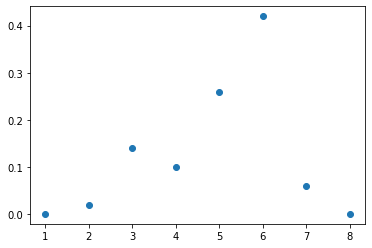

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.1442288273372231
del measure =  0.419786274509804
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


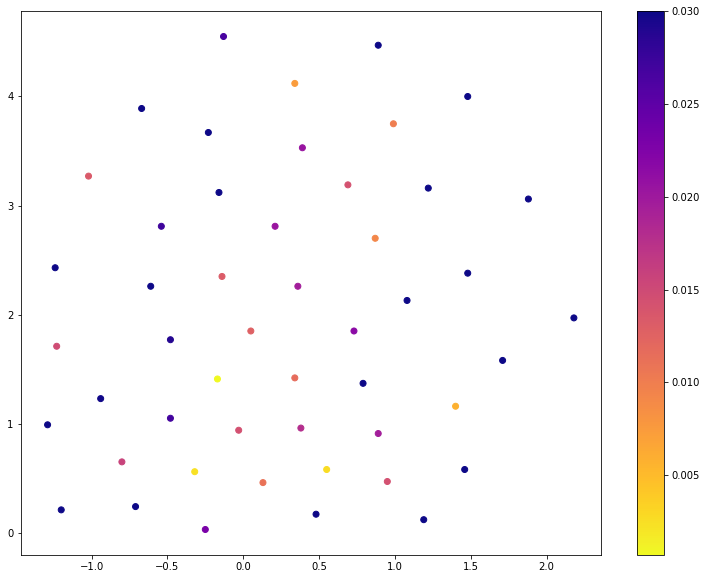

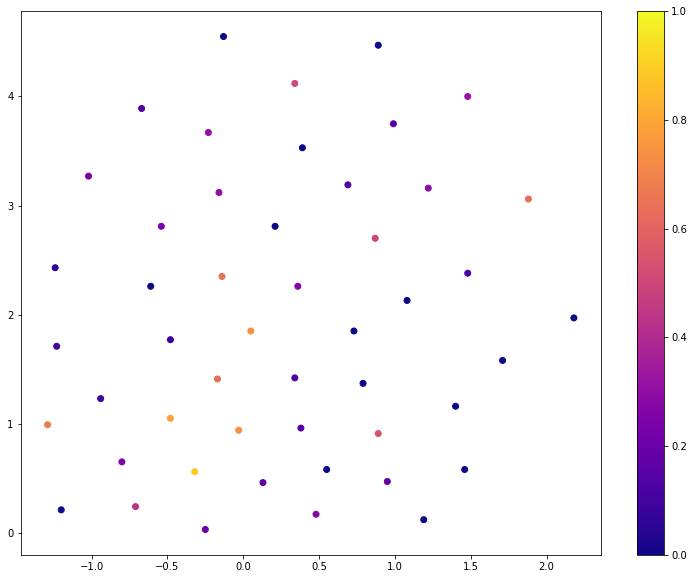

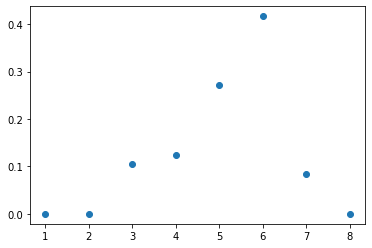

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.08591560179749122
del measure =  0.5611880952380952
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


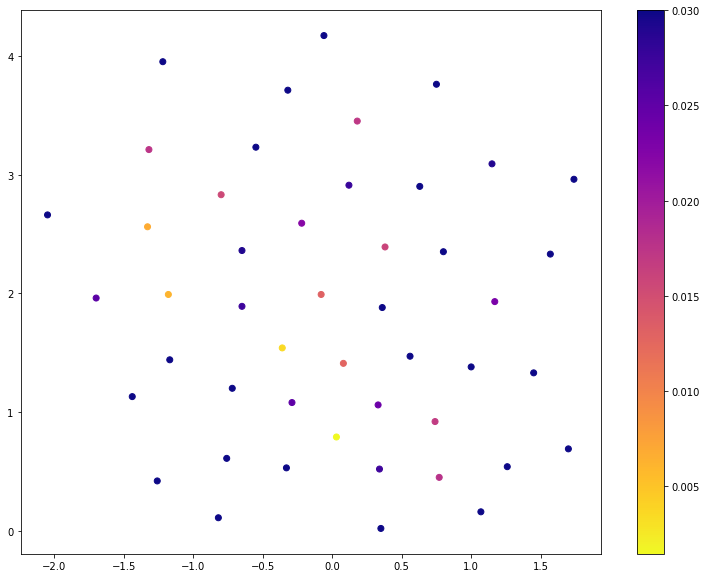

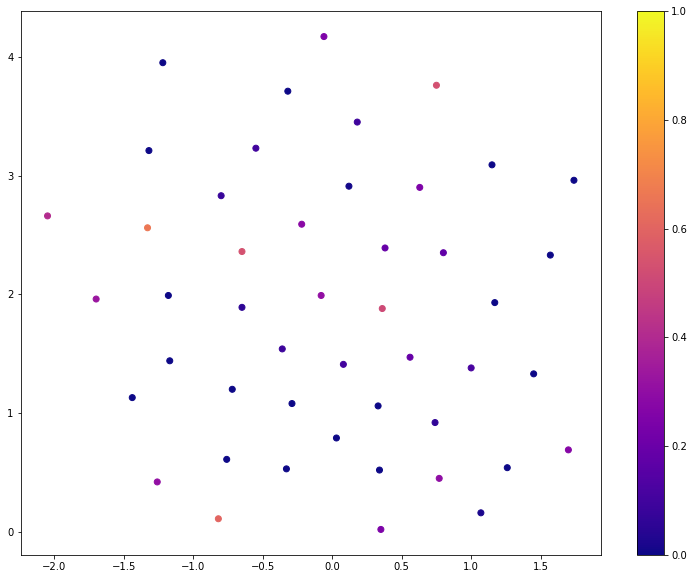

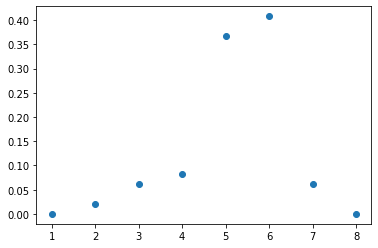

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.12132321208008377
del measure =  0.552188372093023
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


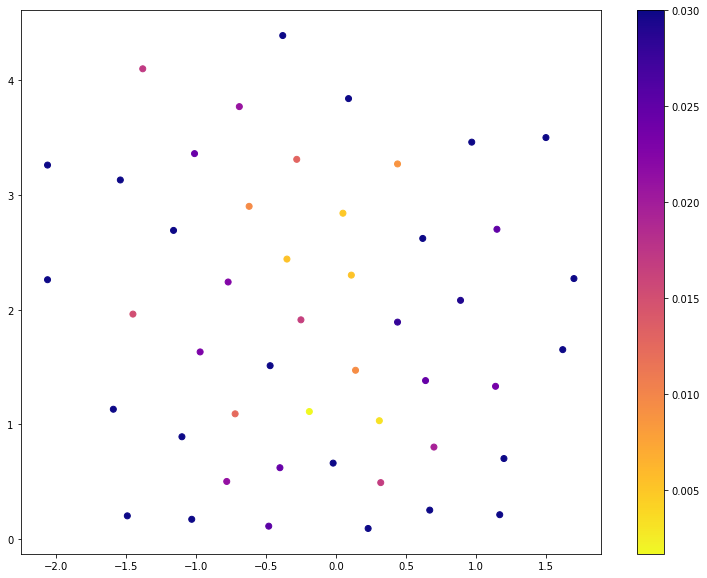

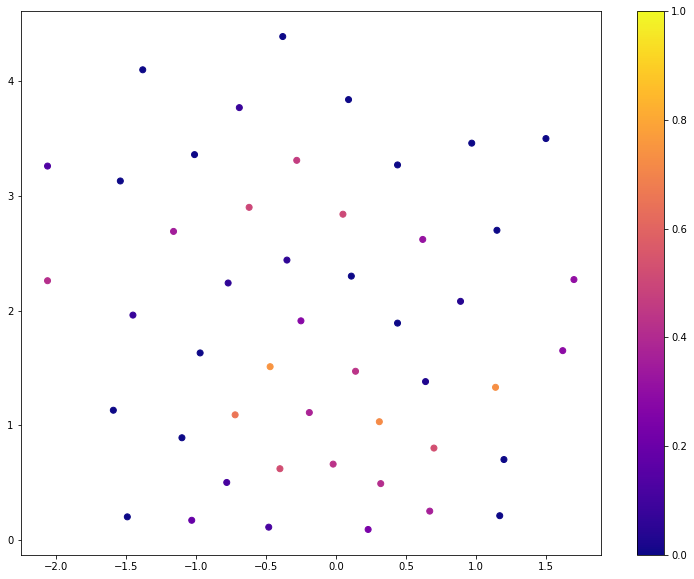

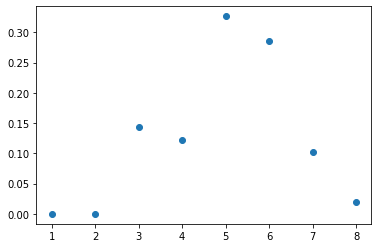

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.16574292800841217
del measure =  0.3812896825396826
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


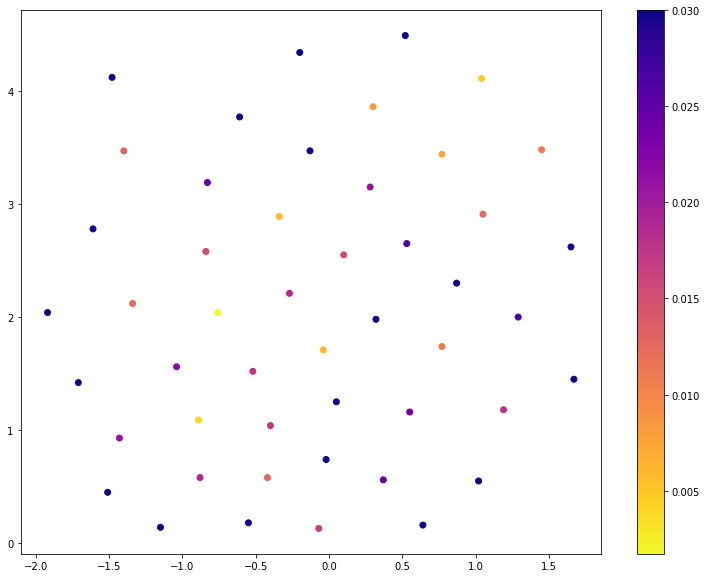

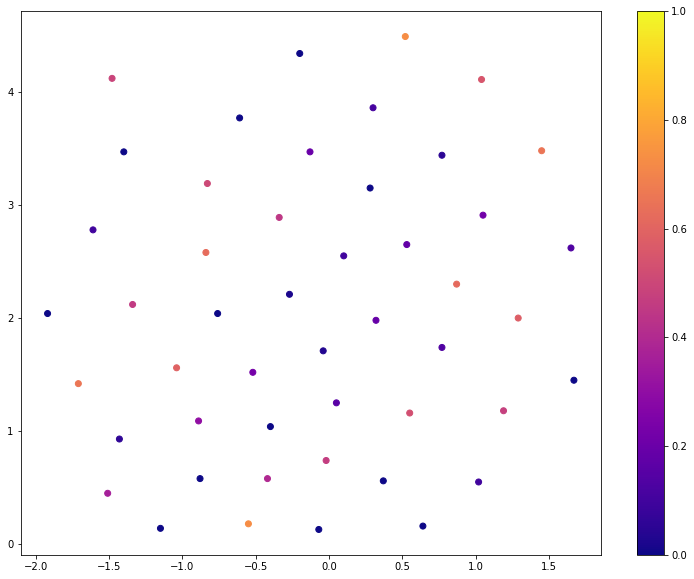

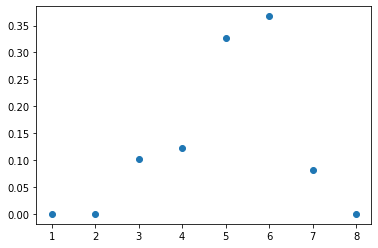

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.13893369359532373
del measure =  0.4193976470588235
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


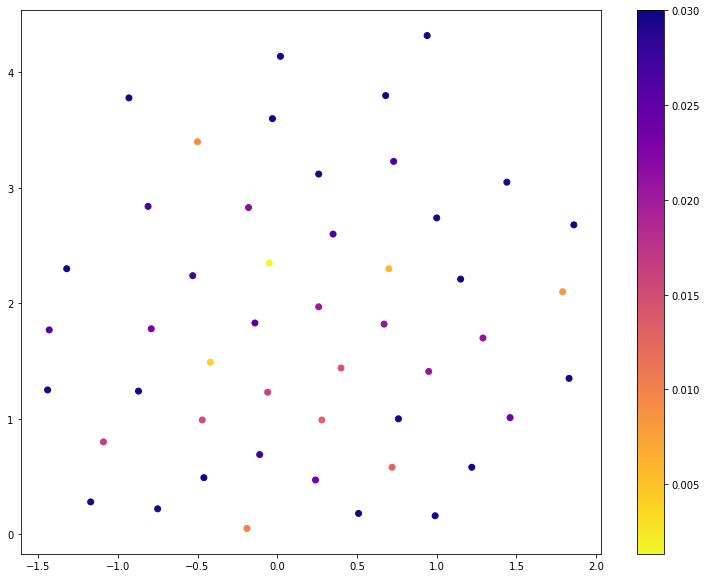

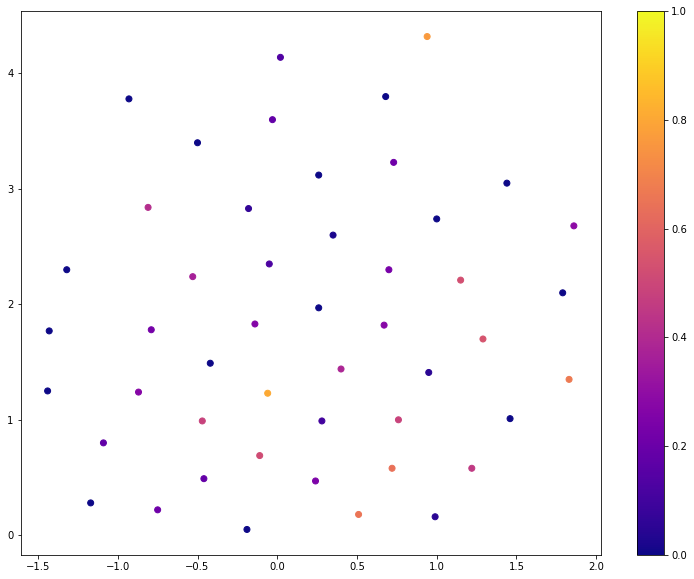

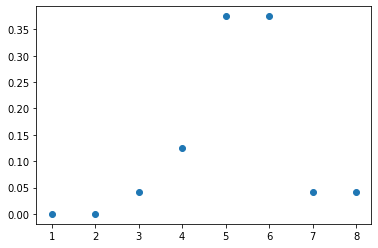

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.1403891374971481
del measure =  0.5483565891472868
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


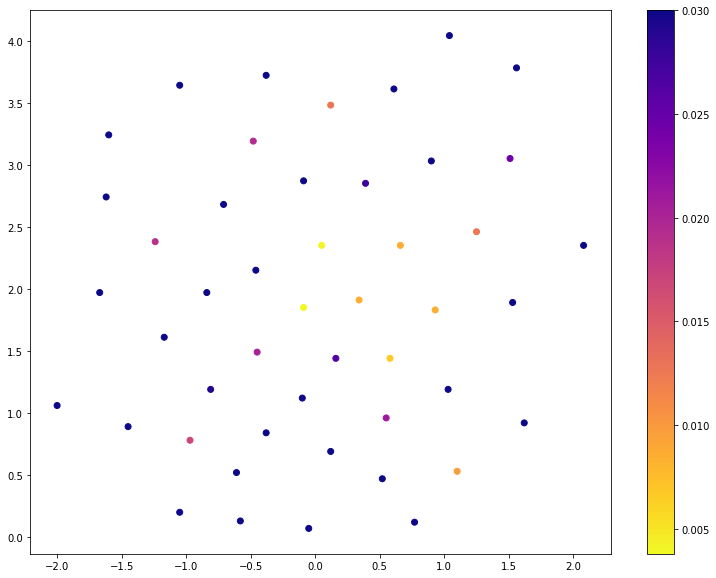

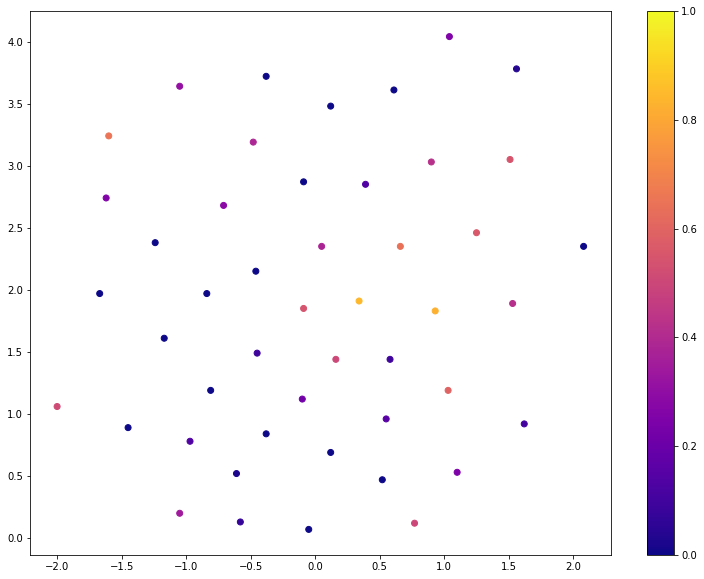

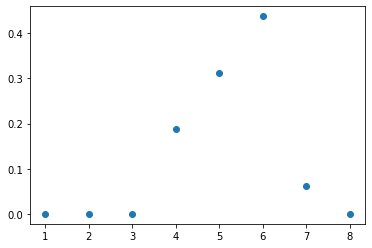

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.0939301534746116
del measure =  0.5372209302325583
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


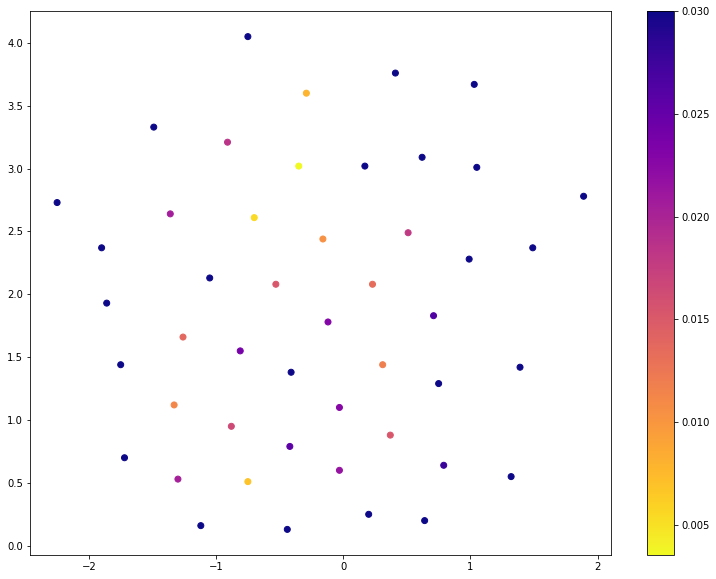

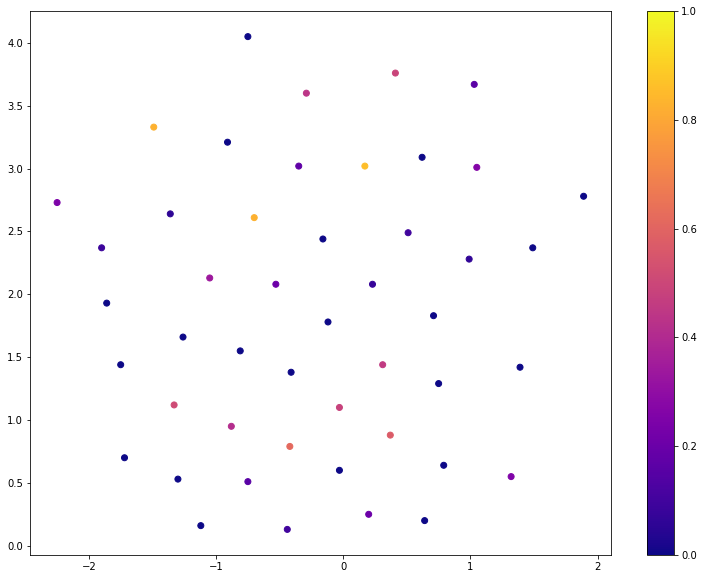

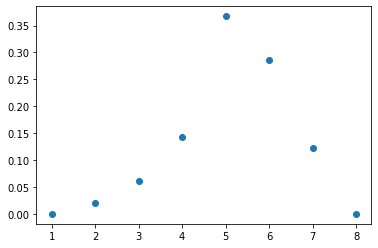

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.16819876197883935
del measure =  0.8133035294117654
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


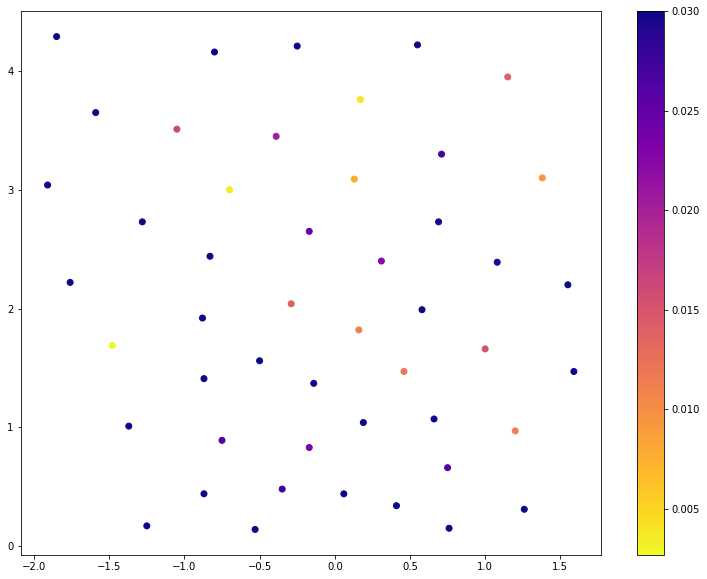

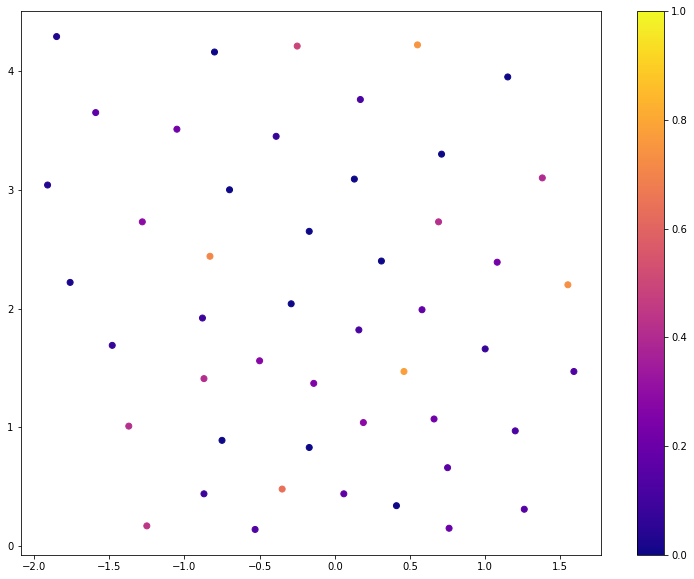

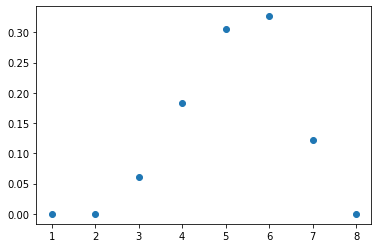

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.12735772244243576
del measure =  0.5422558139534884
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


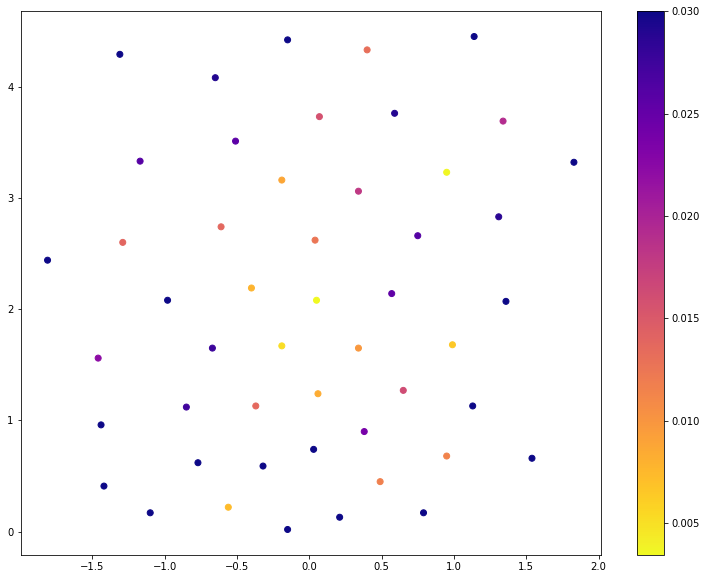

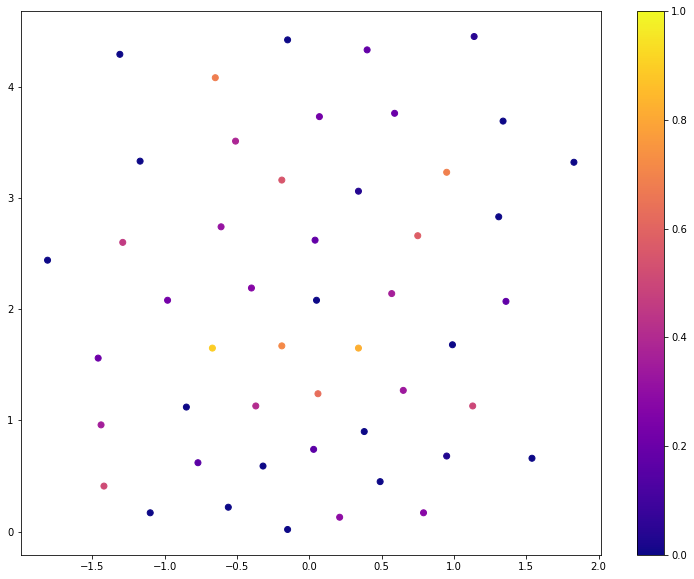

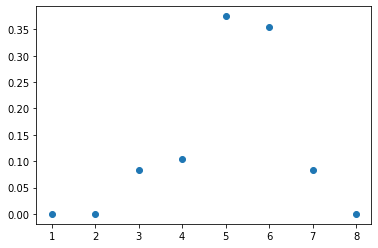

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.03173531459791954
del measure =  0.44351587301587303
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


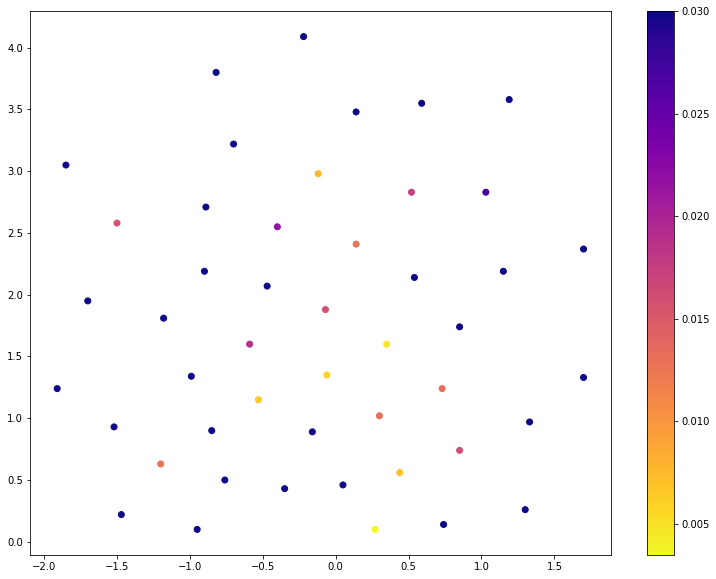

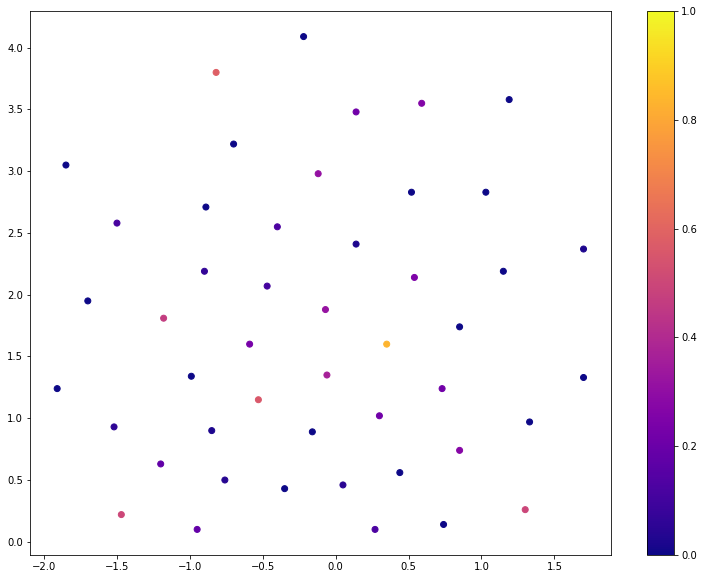

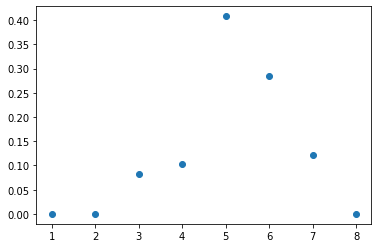

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.07421055909464751
del measure =  0.48652790697674403
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


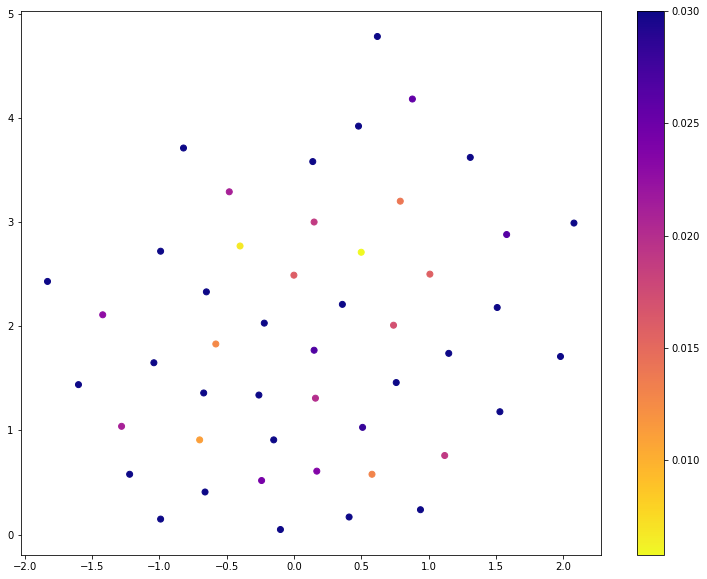

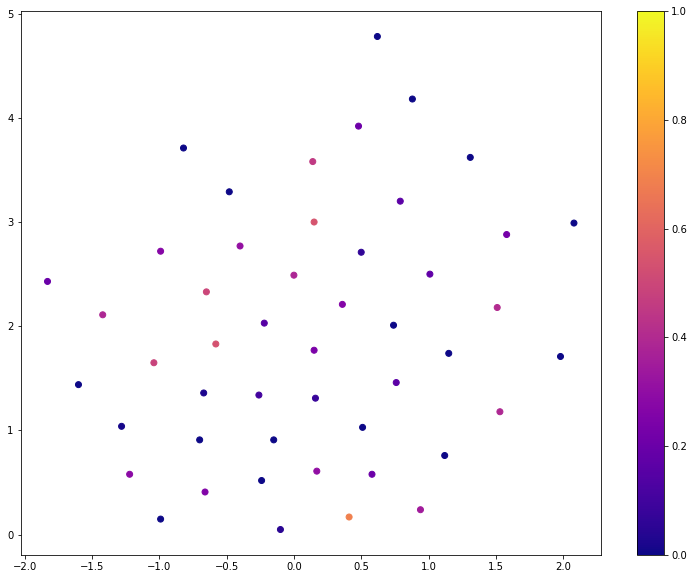

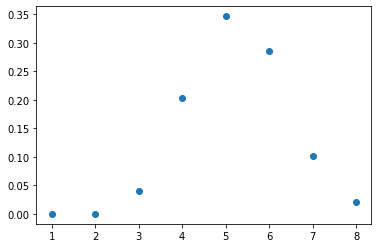

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.13048461396601474
del measure =  0.4619930232558139
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


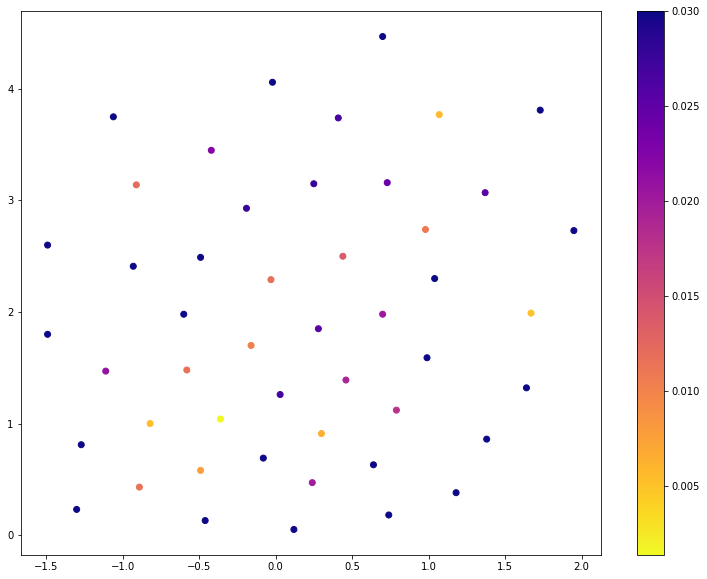

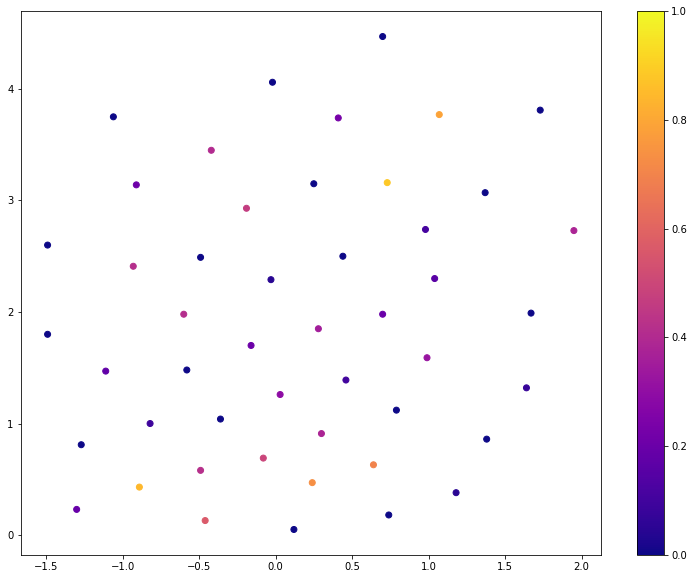

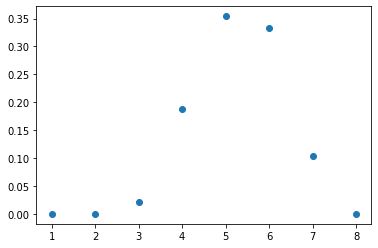

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.05213067672039052
del measure =  0.5056823529411765
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


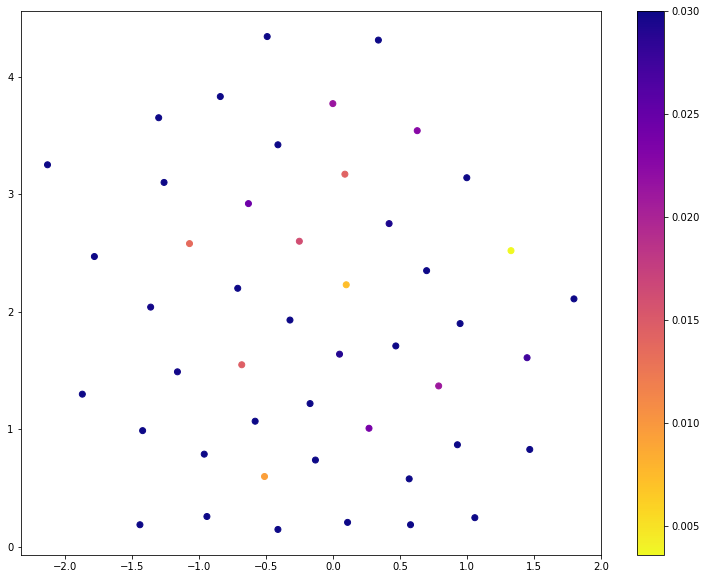

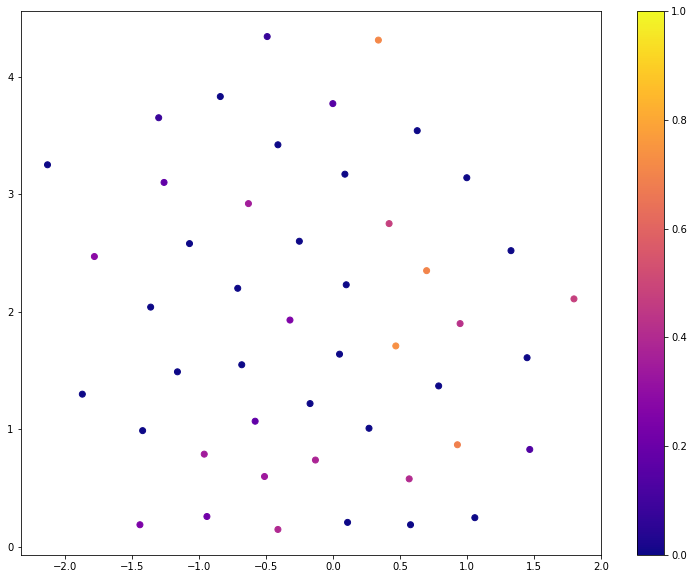

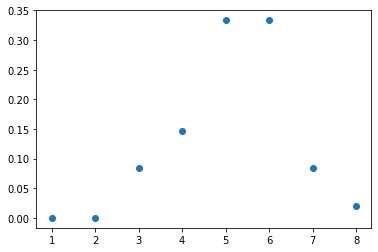

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.068359119570824
del measure =  0.5174880952380951
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


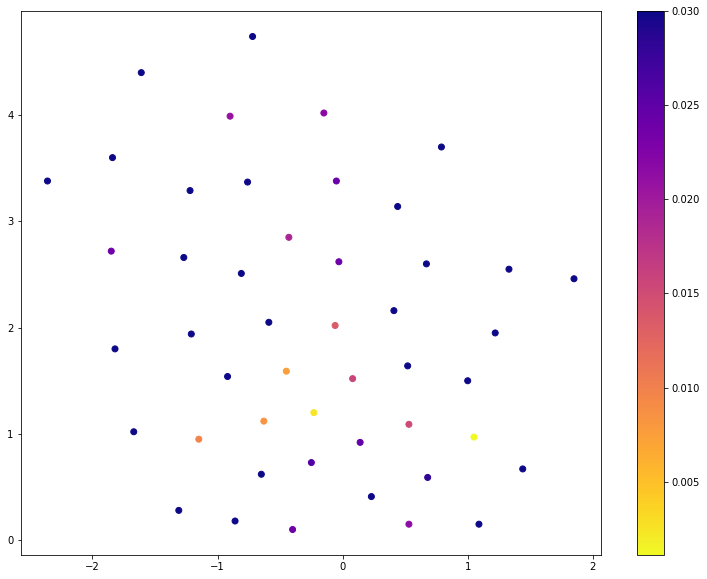

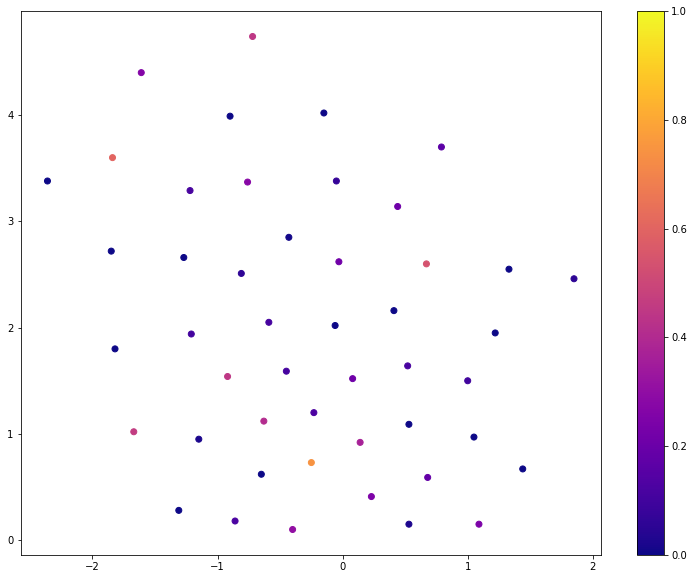

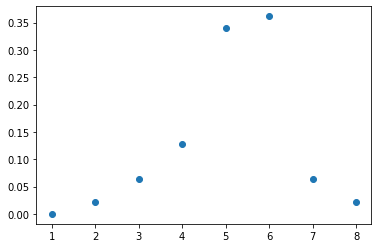

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.16341751914704086
del measure =  0.5371951219512194
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


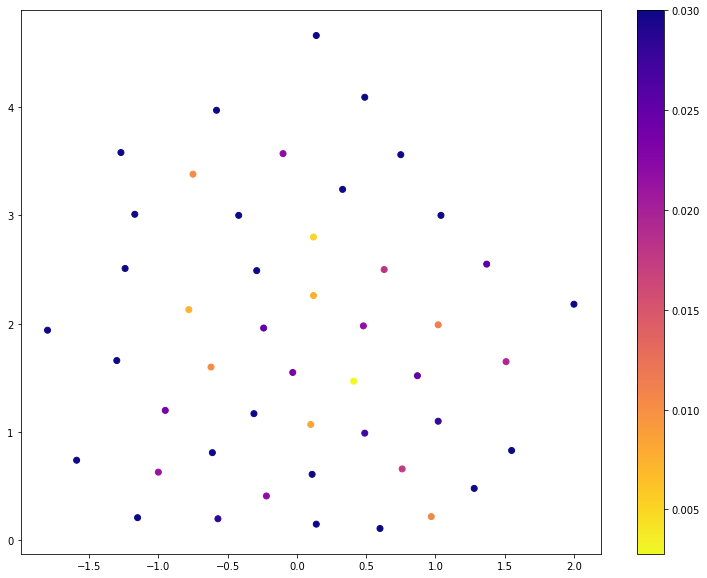

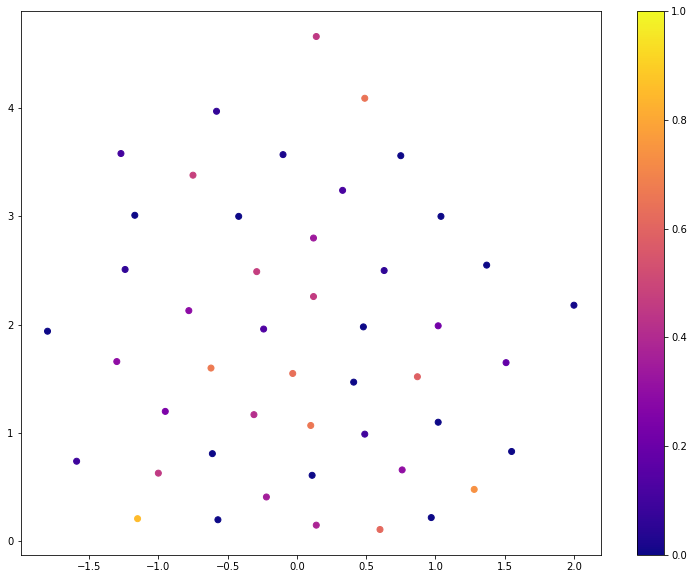

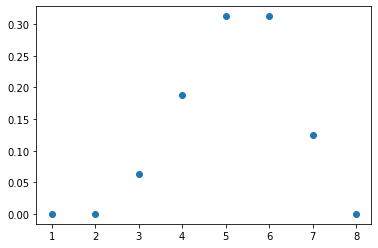

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.16708578192024162
del measure =  1.511654761904762
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


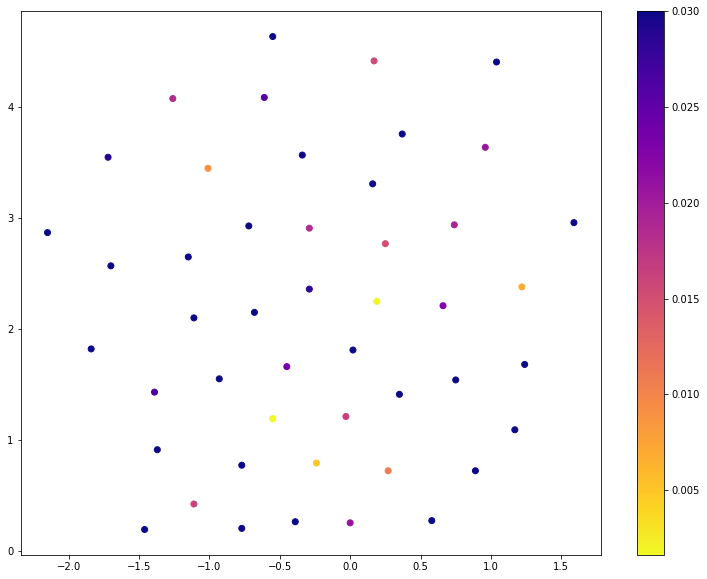

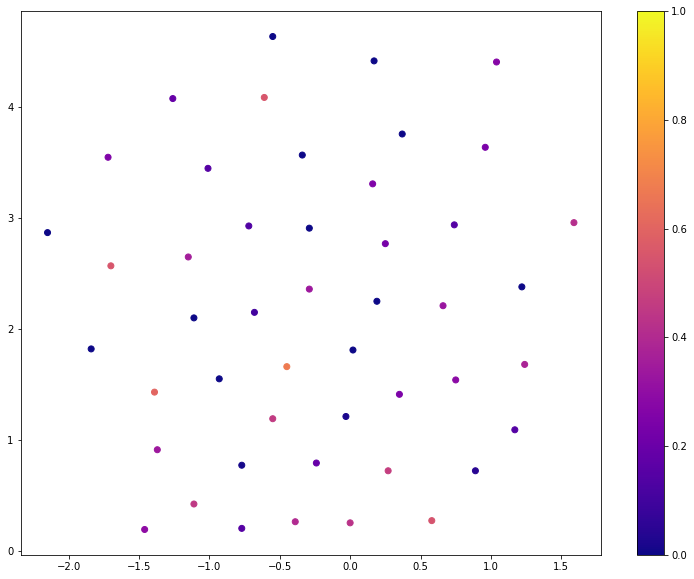

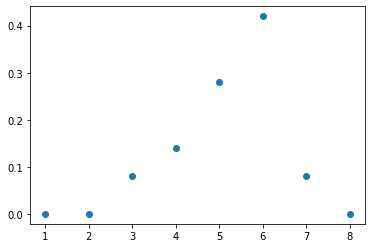

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.07961226917257913
del measure =  0.5591022727272726
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


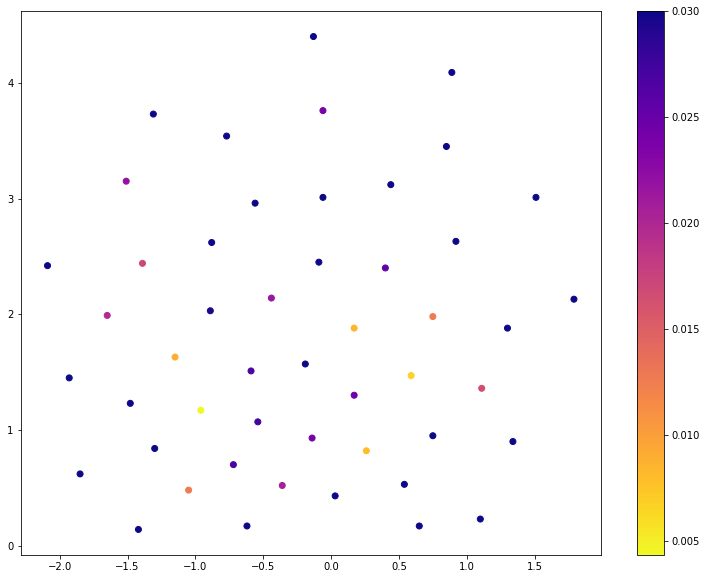

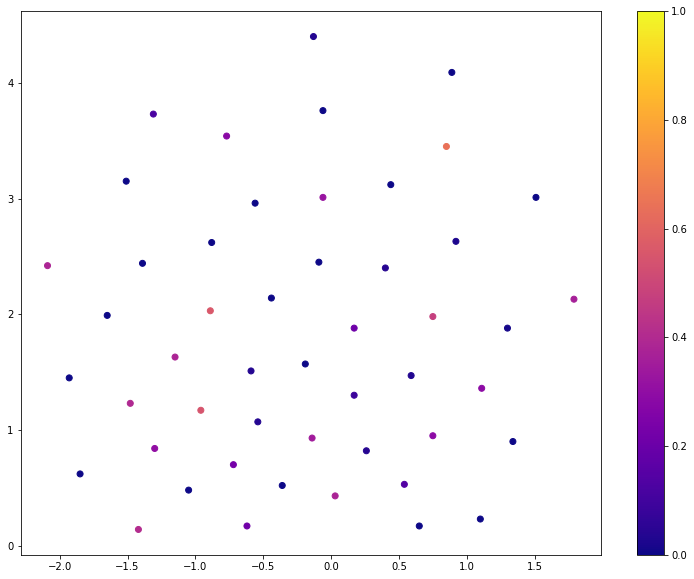

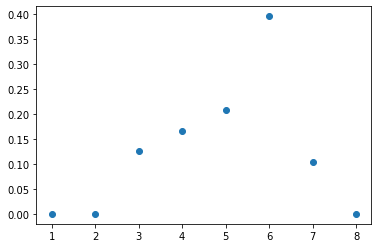

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.1474572227861248
del measure =  0.5094518072289156
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


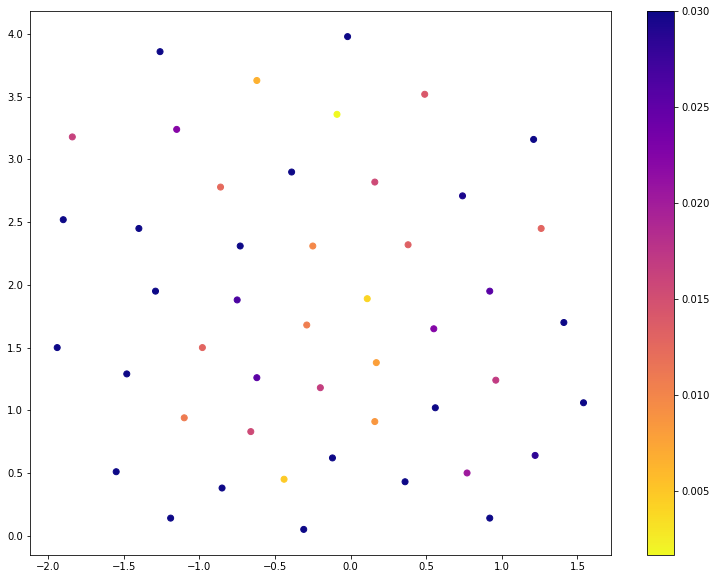

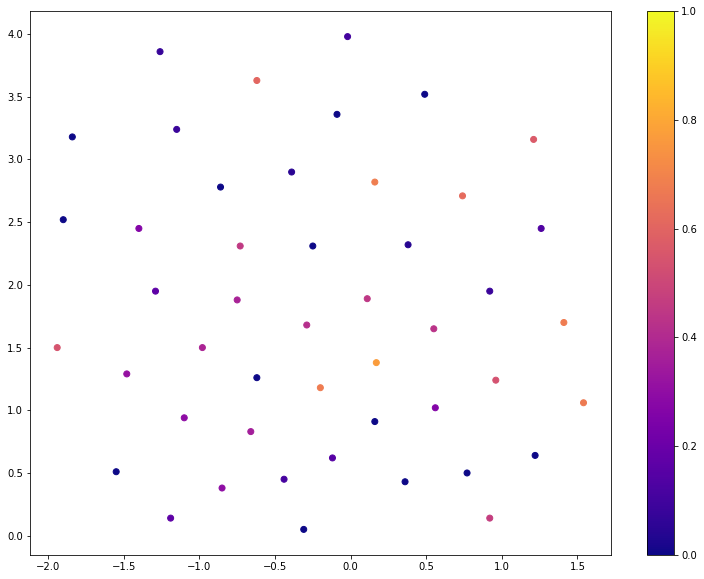

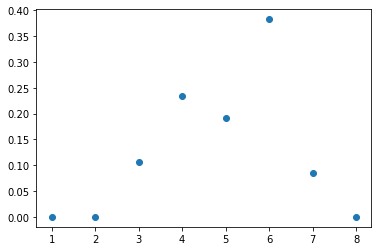

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.20578239330085532
del measure =  0.4121249999999999
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


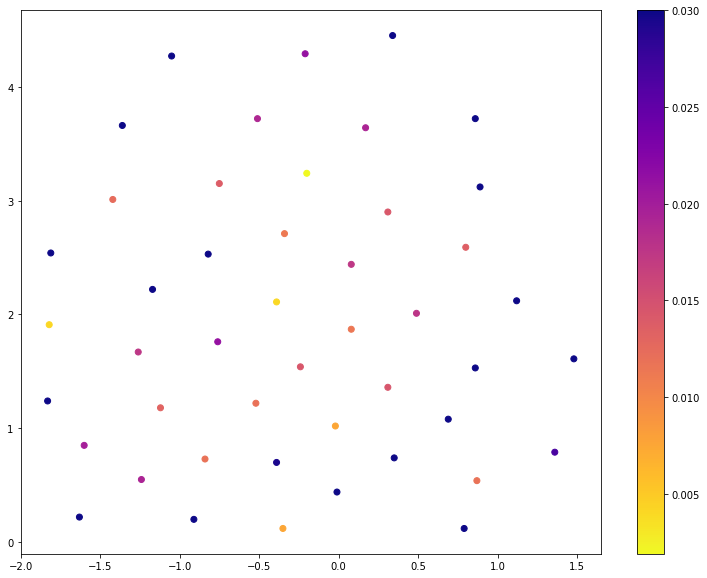

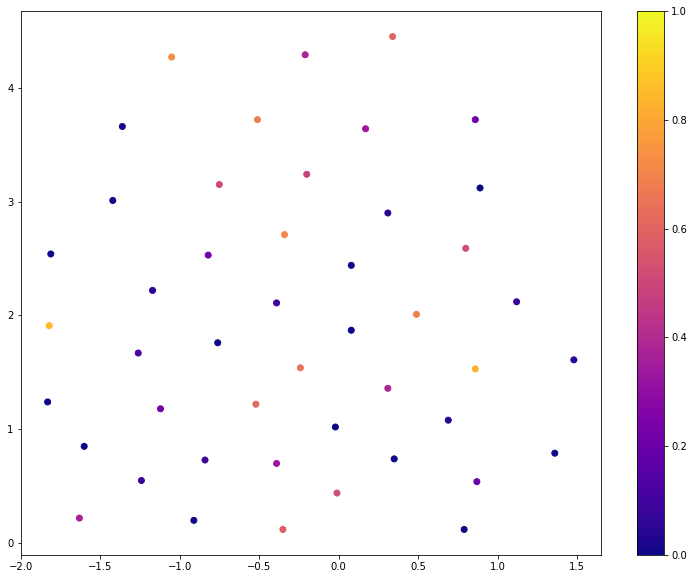

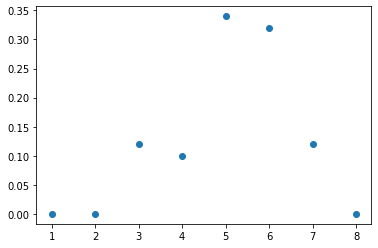

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.0594208513602757
del measure =  1.518618390804597
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


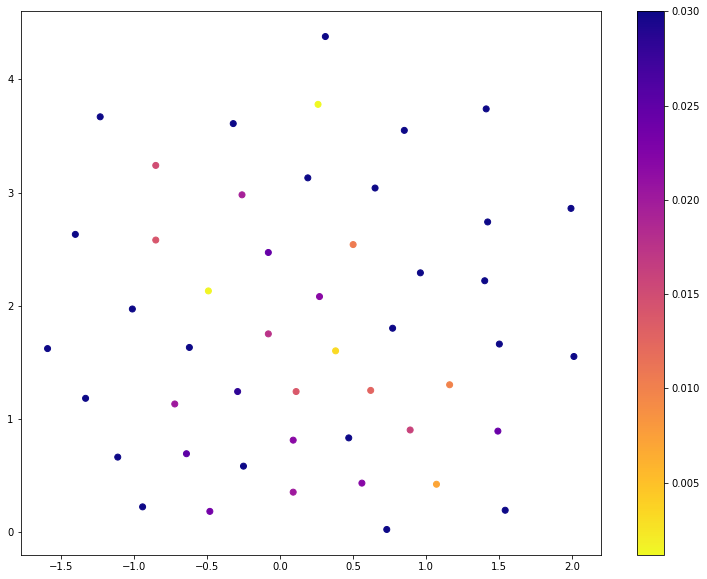

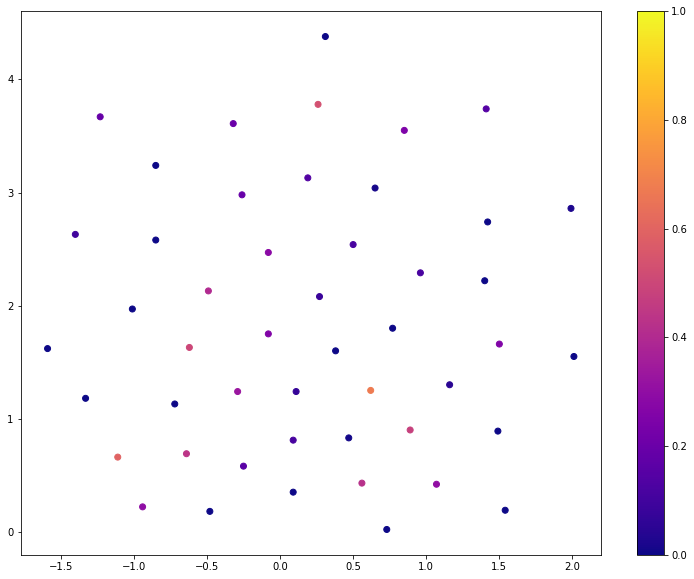

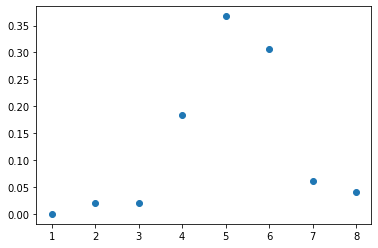

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.06335631423524771
del measure =  0.5329518272425249
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


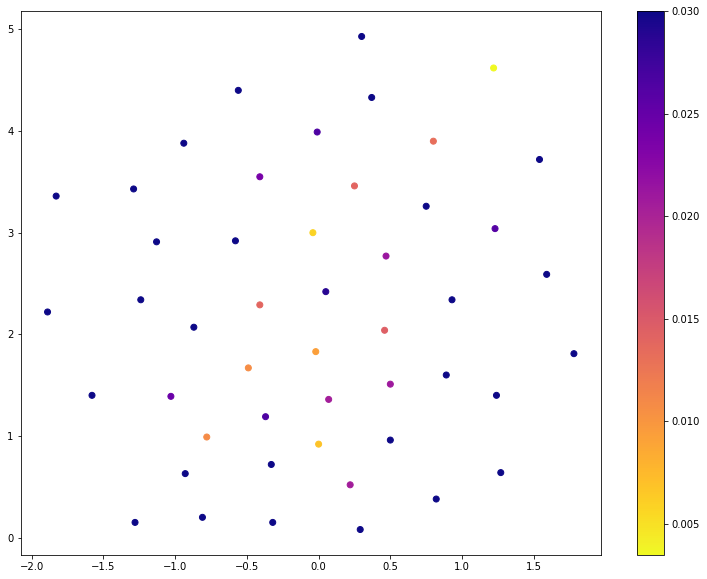

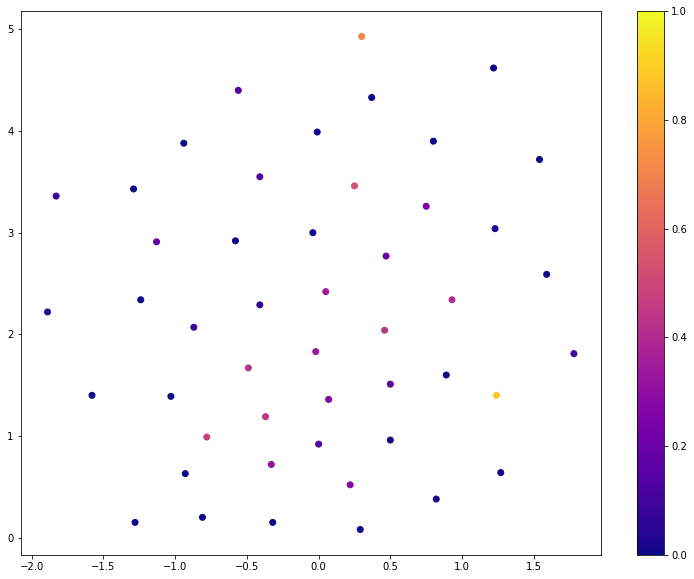

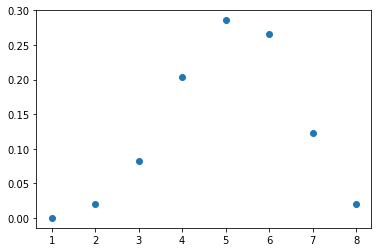

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.06696947853045676
del measure =  0.44663605442176874
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


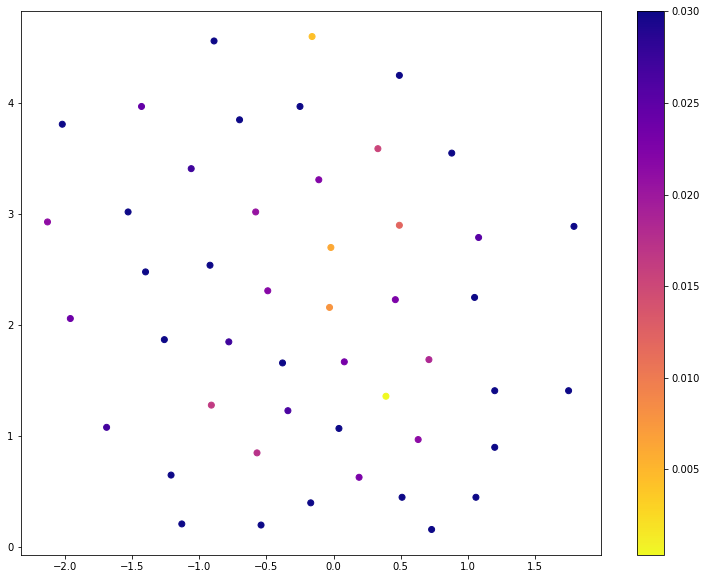

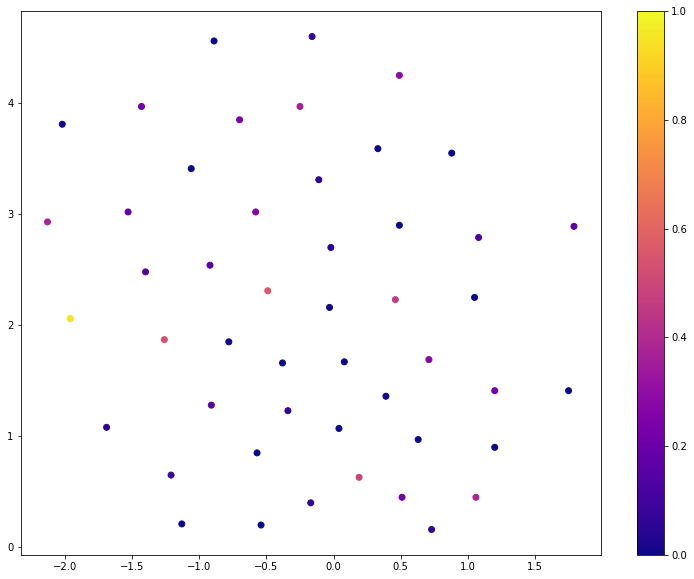

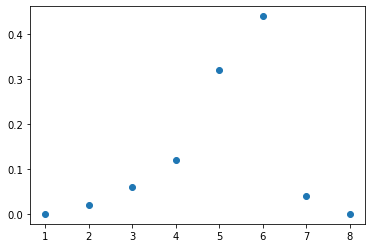

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.06111051202719702
del measure =  0.8649597701149427
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


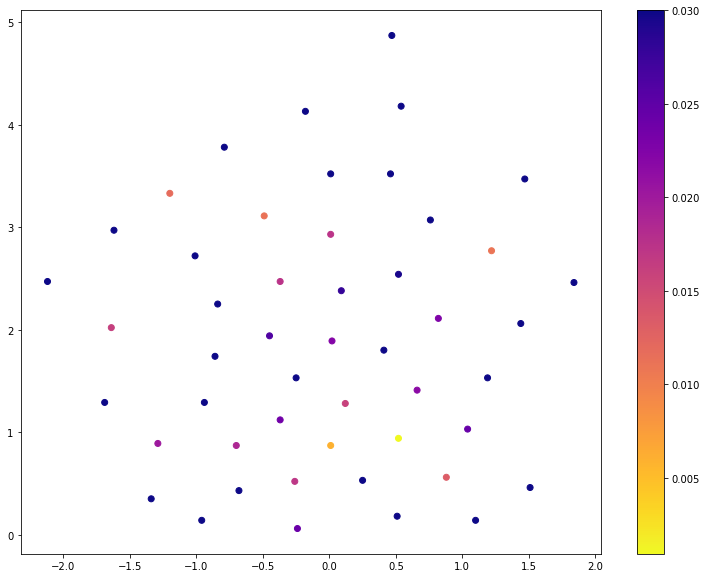

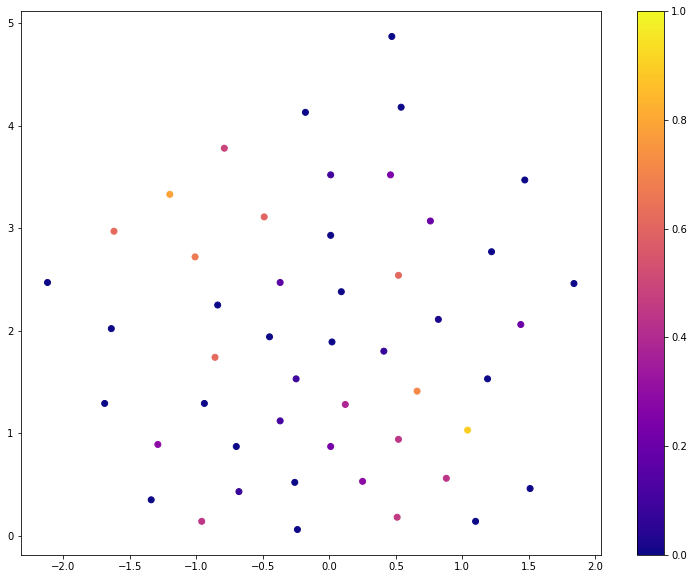

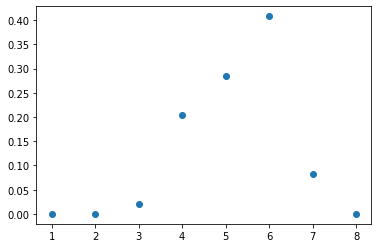

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.0903917758641964
del measure =  0.6360775862068965
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


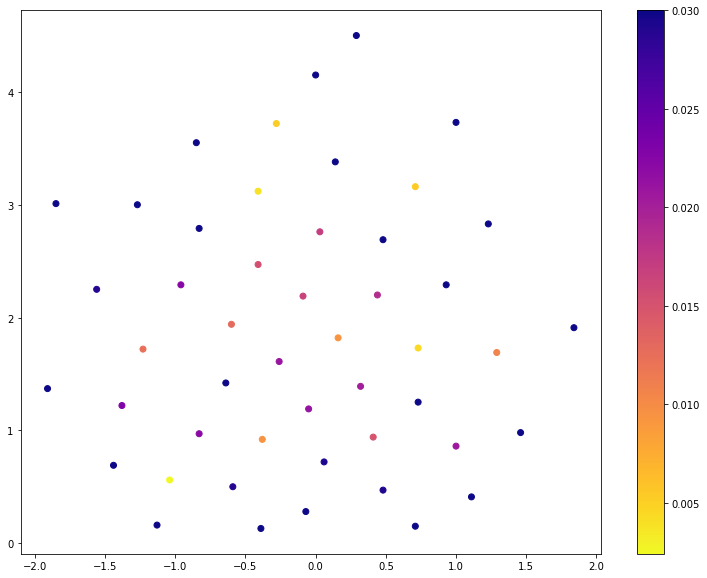

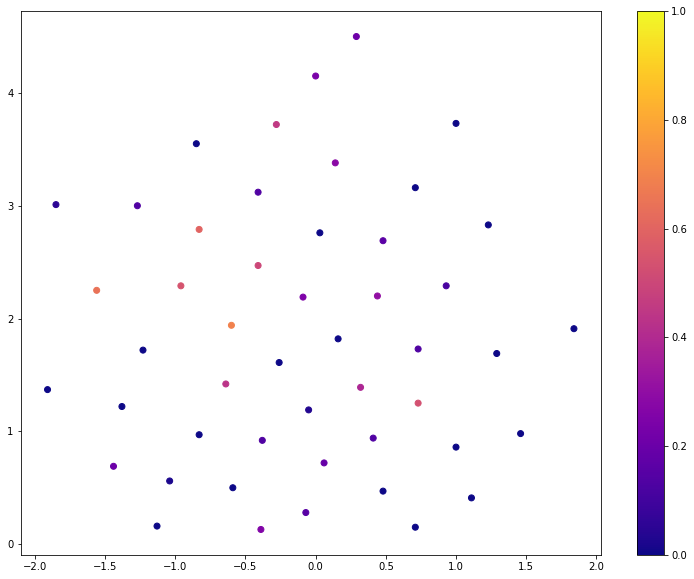

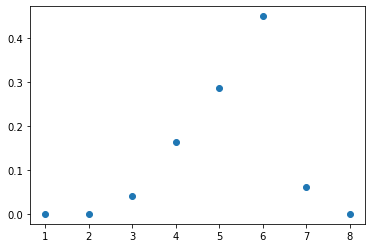

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.20862428080657902
del measure =  0.4566666666666666
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


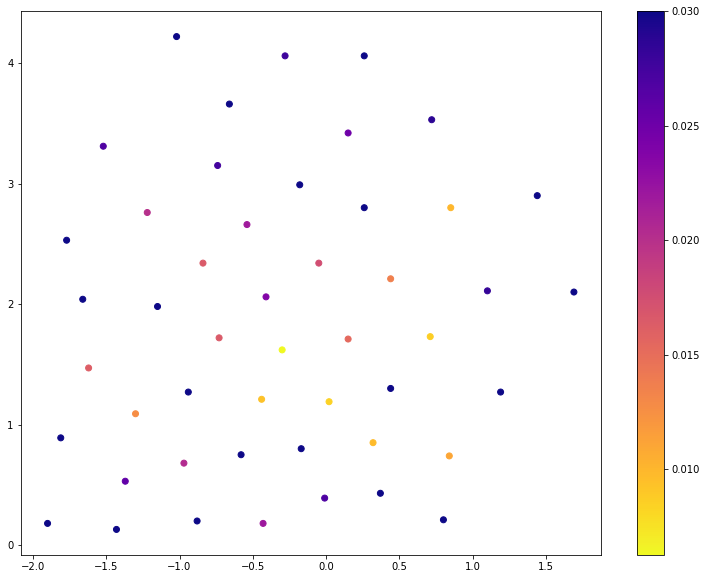

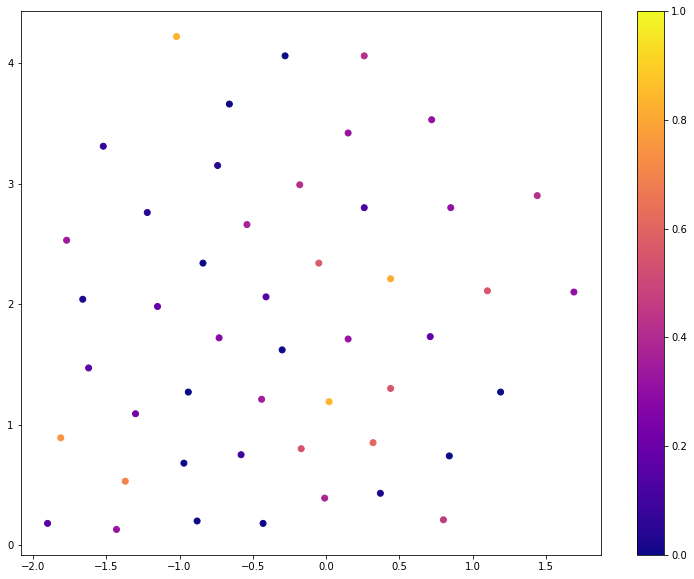

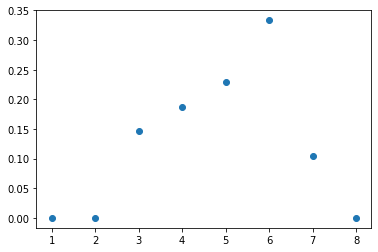

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.0668234800681252
del measure =  0.5513487654320989
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


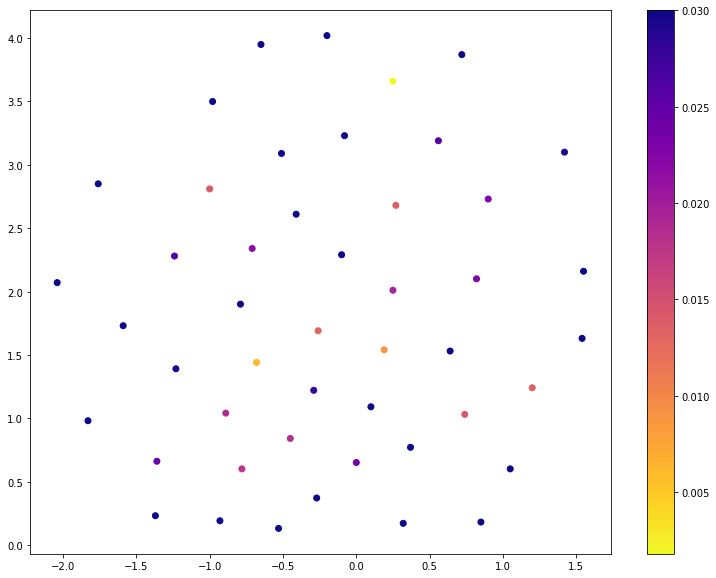

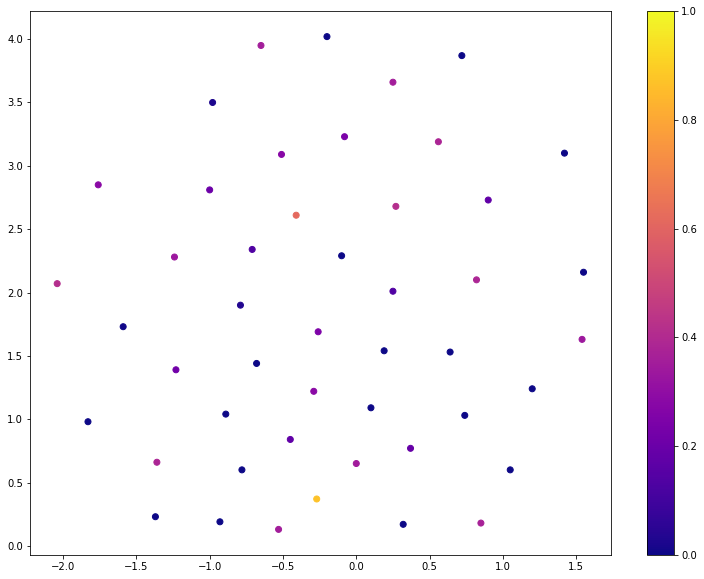

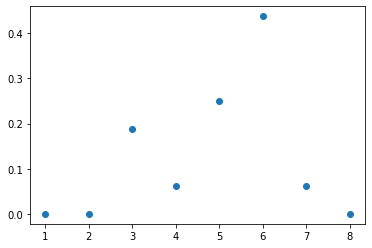

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.060371078703022364
del measure =  0.5238024390243904
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


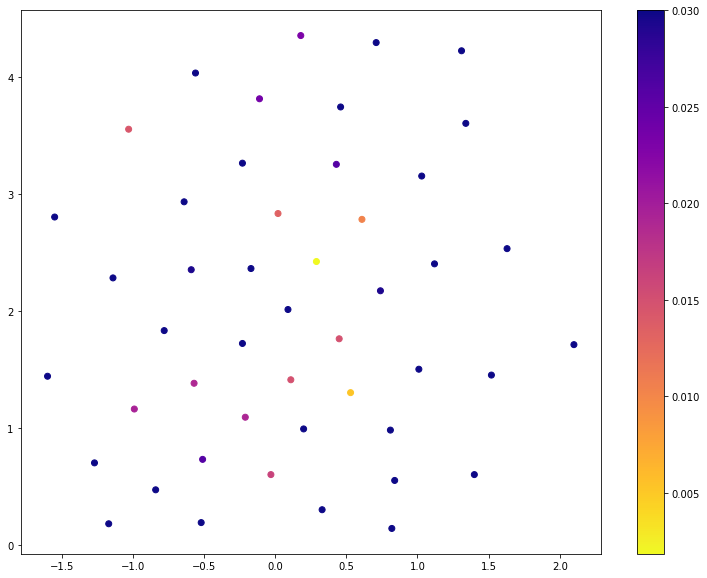

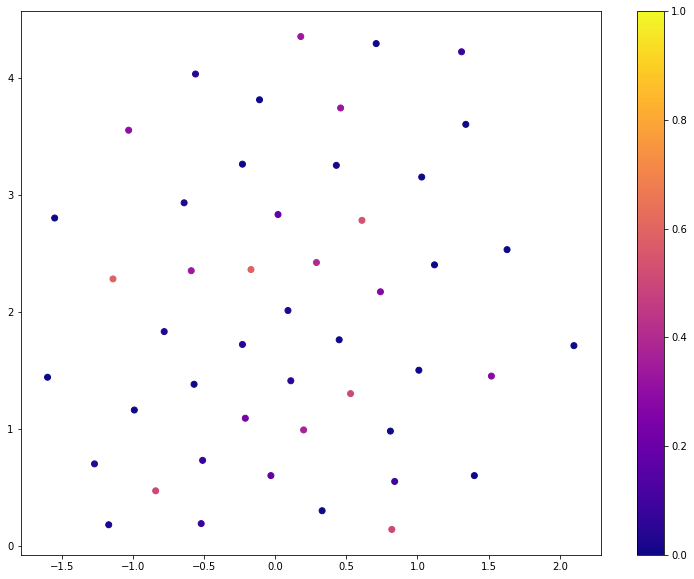

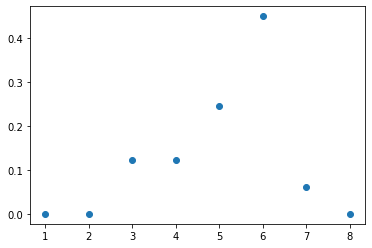

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.15910859048880946
del measure =  0.3801294117647059
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


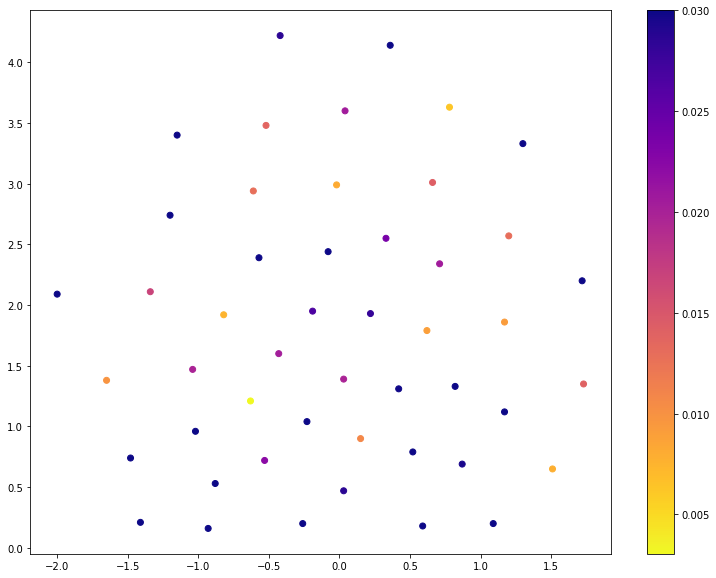

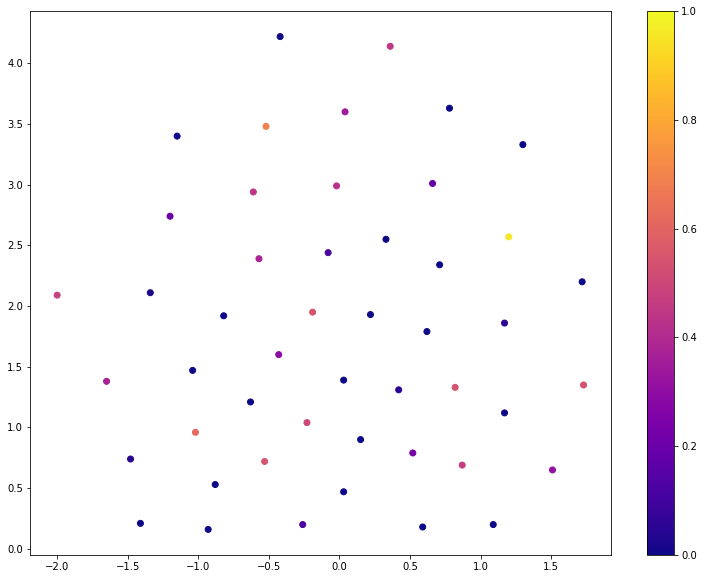

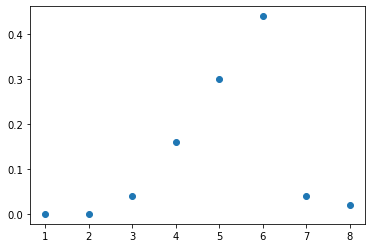

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.13426340708961293
del measure =  0.6324176029962548
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


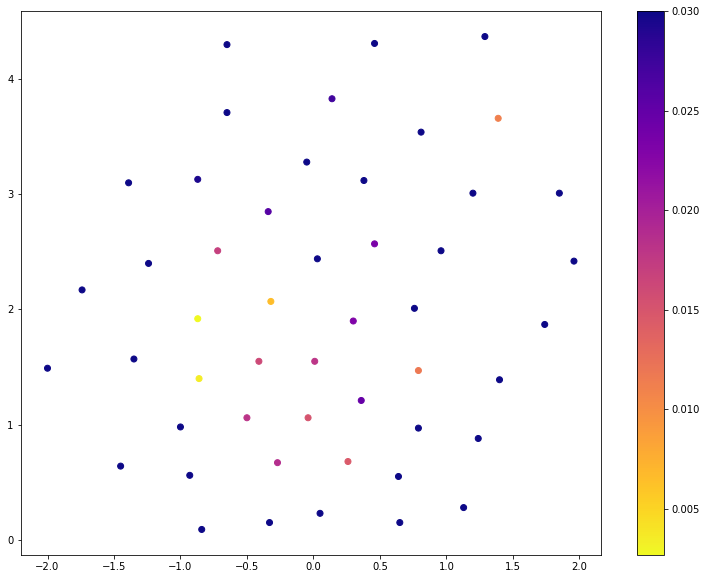

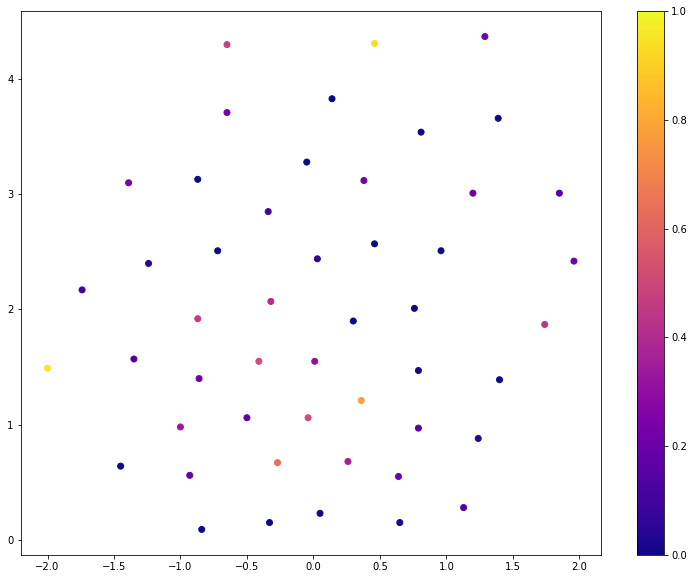

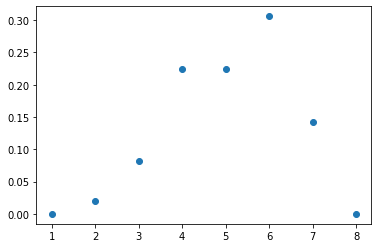

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.036922745621775895
del measure =  0.4998880952380951
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


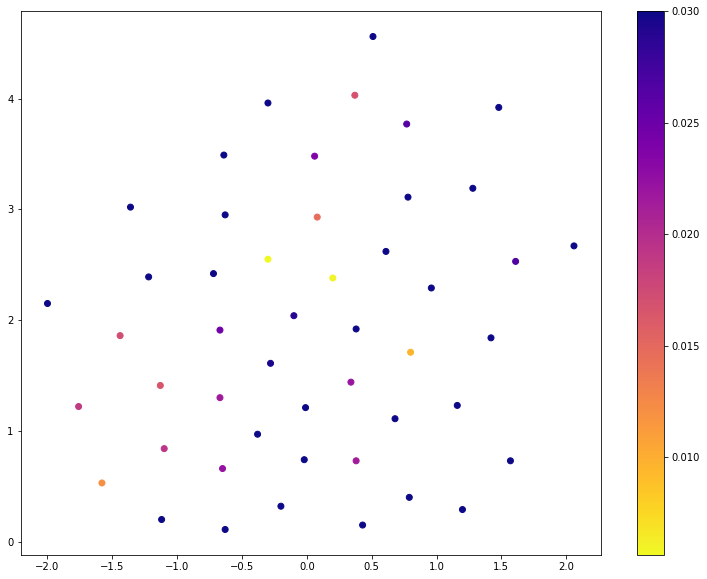

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f850025eef0>
Traceback (most recent call last):
  File "/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py", line 178, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


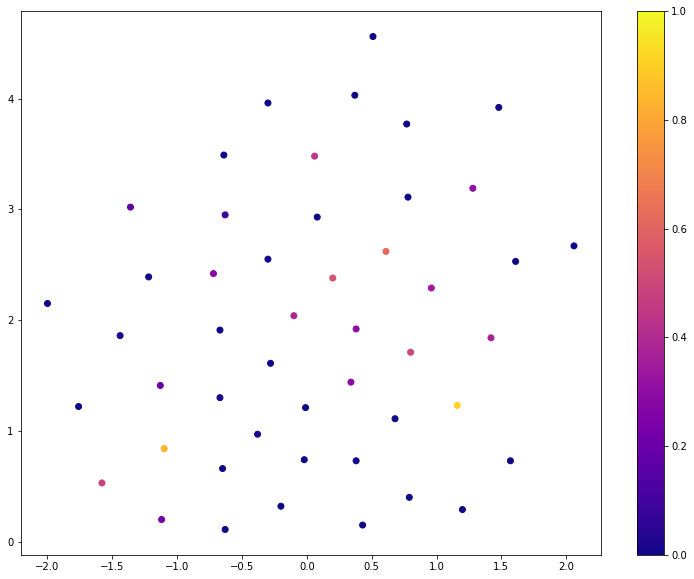

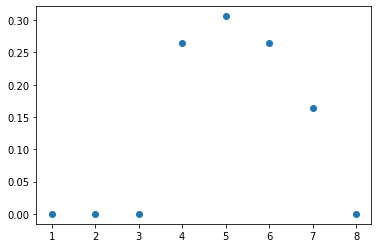

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.06869577248892833
del measure =  0.4863267651888341
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


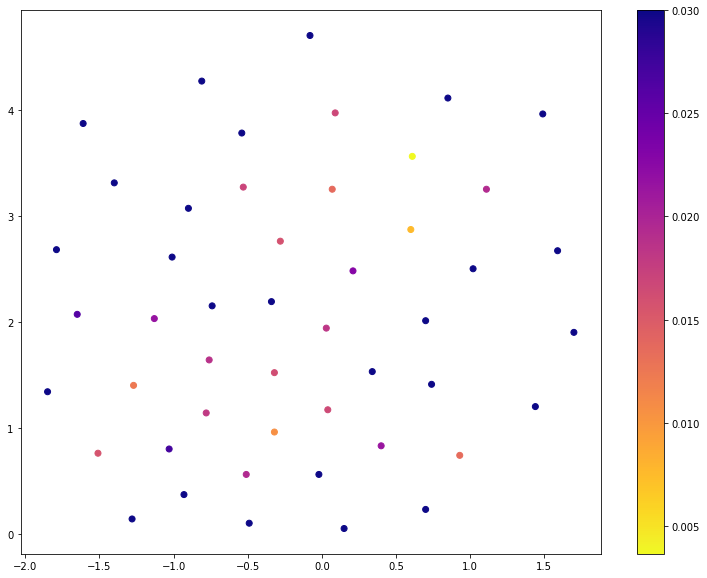

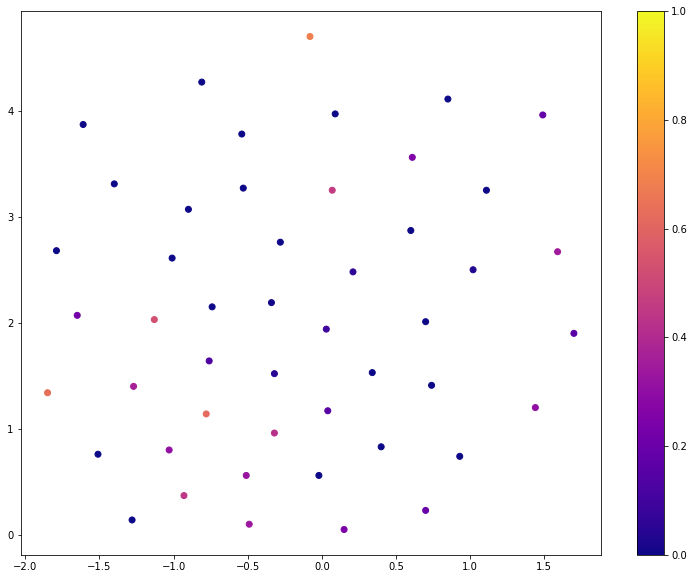

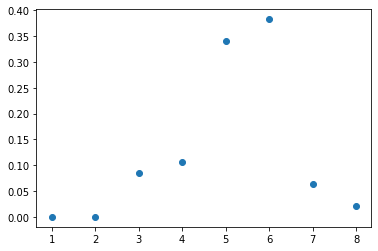

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.09748973544013281
del measure =  0.5516400602409638
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


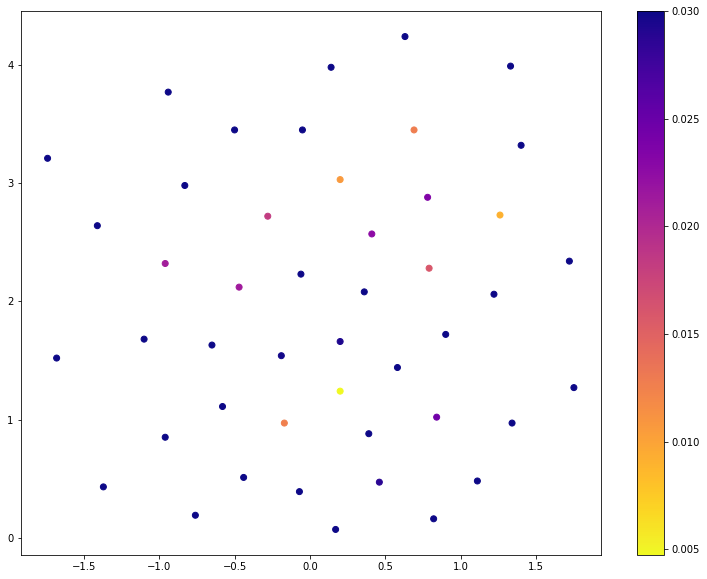

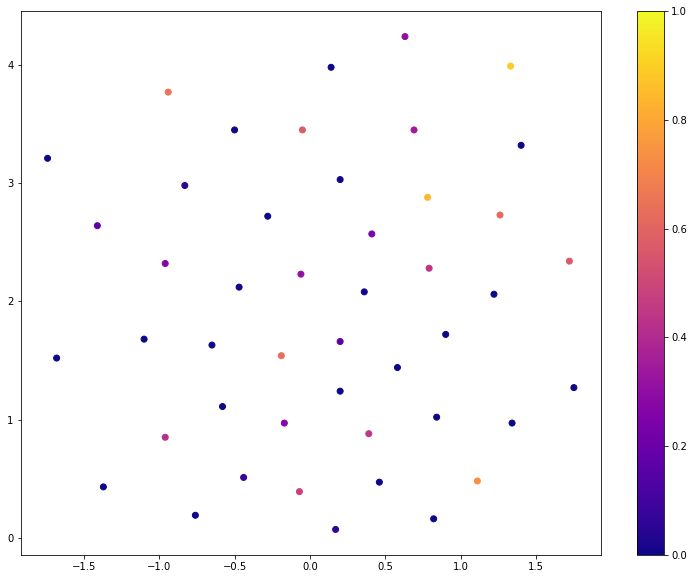

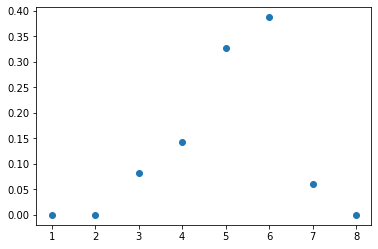

<calc local measure>
<\calc local measure>
<calc global measure>
bond_measure =  0.09513325130904038
del measure =  0.4104490196078432
<\calc global measure>
<calc order field>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


<\calc order field>


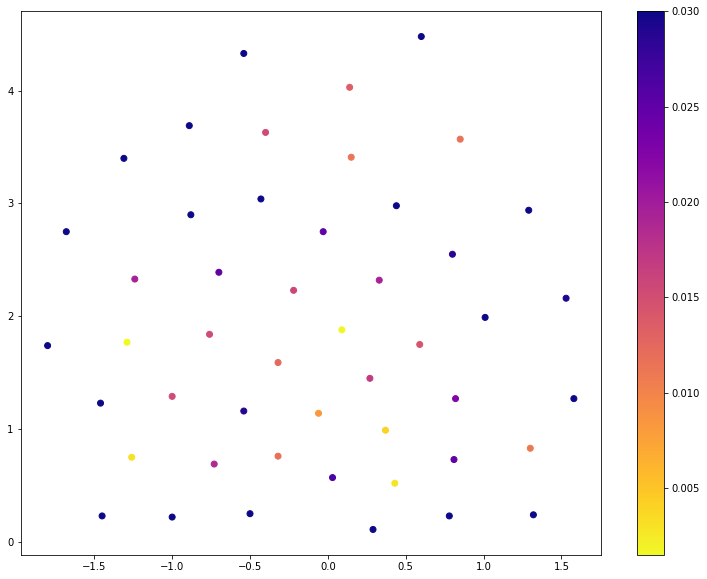

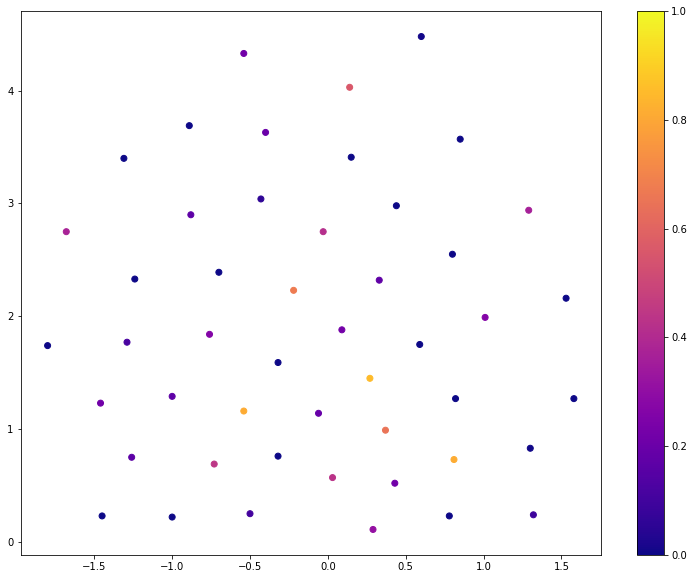

KeyboardInterrupt: 

In [205]:
col = ["FR","X","Y"]
#col = ["id" ,"frame", "x/cm", "y/cm"]

blist = 2 * lin_var[test_var]
v_0_list = []
from itertools import groupby
N_del_i = 10
N_del = 10
fps = 16
os.system("mkdir " + path + "plots/structure")
os.system("mkdir " + path + "plots/structure/dist_factor")
os.system("mkdir " + path + "plots/structure/bond_factor")


for T_test in T_test_list[0:1]:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])
    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(N_runs)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    bond_array_1 = []
    del_m_array_1 = []
    order_matrix_2 = []
    for loc_list_runs in loc_list[50:51]:
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")
        p0count = 0
        count = 0
        incount = 0
        bond_array = []
        del_m_array = []
        order_matrix_1 = [] 
        for loc in loc_list_runs:
            if os.path.isfile(loc) == False:
                #print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            #df = pd.read_csv("exp_results/trajectories/sieben.txt", header=0, comment="#",skipinitialspace=True, sep = " ")
            #df = pd.read_csv("trajectories/ini_lm_N_ped20000_tmax300_size_0_2_fps_16_testvar_b/ini_41_6_lm_20000_esigma_0_7_tmax_300_periodic_0_v0_1_34_T_1_0_rho_ini_2_0_Nped_20000_0_motfrac_1_0/stitch_new_evac_traj_83_2_0.txt", sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            #df = pd.DataFrame({'X':df['x/m'].values/100,'Y':df['y/m'].values/100,"FR":df['frame'].values})
            #print(df)
            del_m_list = []
            bond_list = []
            #time_list = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,98,99,90,91]
            #time_list = np.arange(0,300,1)
            #time_list = np.arange(0,300,150)
            time_list = np.array([10])
            for second in time_list:
                x = df[df['FR'] == second * fps]['X'].values#/100
                y = df[df['FR'] == second * fps]['Y'].values#/100
                #x = np.random.rand(100) * 5
                #y = np.random.rand(100) * 5
                #x,y = hexagonalLattice(50,1,0.1,-1,1,1)
                #x = x[0]
                #y = y[0]
                XY = pd.DataFrame({'x':x,'y':y})
                x = XY['x'].values
                y = XY['y'].values

                points = np.vstack((x,y)).T
                tri = Delaunay(points)
                dist_tri,dist = latticeDistance(tri)
                
                unique, counts = np.unique(tri.simplices, return_counts=True)
                nphist = np.histogram(counts,density = True,bins=range(1, 10))
                plt.plot(nphist[1][:-1],nphist[0], marker = "o", linestyle='none')
                plt.show()
                
                N = x.shape[0]
                print("<calc local measure>")
                neighbour_list, neigh_dist_list, local_bond_list = localOrientationMeasures(tri,N)
                print("<\calc local measure>")

                XY['Nn'] = neighbour_list
                XY['Dm'] = neigh_dist_list
                XY['Bf'] = local_bond_list
                
                print("<calc global measure>")
                dist = indexDistance(0,tri)
                bond_measure = bondOrientationFactor(tri,N)
                print("bond_measure = ", bond_measure)
                bond_list.append(bond_measure)

                dist_tri = np.round(dist_tri,3)
                dist = np.array(dist)
                dist = np.round(dist,3)
                del_m = delHexMeasure(dist_tri,dist)
                
                print("del measure = ", del_m)
                del_m_list.append(del_m)
                print("<\calc global measure>")

                x_array = np.linspace(-2,2,40)
                y_array = np.linspace(0,2,20)
                #x_arr = [x_array for i in range(1)]
                #y_arr = [y_array for i in range(1)]
                #r_array = np.linspace(0,2,5)
                #phi_array = np.linspace(0,2 * 3.1415,100)
                #g_r_phi = cff.correlation_data(np.array([x_l]),np.array([y_l]),x_arr,y_arr,r_array,phi_array,0.15)
                
                #XY20 = XY_red[XY_red['x'].values ** 2 + XY_red['y'].values ** 2 < 20 ** 2]
                #y = XY[XY['x'].values ** 2 + XY['y'].values ** 2 < 20 ** 2]['y'].values
                print("<calc order field>")
                XY_red = pedReducer(XY,-2,20,0,20,300)
                order_matrix = orderField(XY_red['x'].values,XY_red['y'].values,XY_red['Bf'].values,x_array,y_array,0.06)
                order_matrix_1.append(order_matrix)
                print("<\calc order field>")
                
                #normal_matrix = normal(XY_red['x'].values,XY_red['y'].values,x_array,y_array,0.175)
                radius = []
                Dm_list = []
                #print(order_matrix)
                
                #unique, counts = np.unique(XY_red['Nn'].values, return_counts=True)

                """ fig, ax = plt.subplots(figsize = (9, 9))
                color_dict = {2:"royalblue",3:"lightgreen",4:"lawngreen",5:"deepskyblue",6:"red",7:"navy",8:"gold",9:"orange",10:"yellow",11:"chocolate"}
                for i in np.arange(12,100):
                    color_dict[i] = ["chocolate"]
                g =sns.scatterplot(x="x", y="y",hue="Nn",data=XY_red,palette = color_dict);
                g.set()
                plt.savefig(path + "plots/structure/neigh" + str(second) + ".png")"""
                #plt.show()
                
                fig, ax = plt.subplots(figsize = (13, 10))
                cm = plt.cm.get_cmap('plasma_r')
                sc = plt.scatter(XY_red['x'].values,XY_red['y'].values, c = XY_red['Dm'].values, cmap=cm,vmax = 0.03)
                fig.colorbar(sc)
                plt.savefig(path + "plots/structure/dist_factor/dist" + str(second) + ".png")
                plt.show()
                
                fig, ax = plt.subplots(figsize = (13, 10))
                cm = plt.cm.get_cmap('plasma')
                sc = plt.scatter(XY_red['x'].values,XY_red['y'].values, c = XY_red['Bf'].values, cmap=cm,vmax = 1,vmin = 0)
                fig.colorbar(sc)
                plt.savefig(path + "plots/structure/bond_factor/dist" + str(second) + ".png")
                plt.show()
                
                """plt.xlim([-6,6])
                plt.ylim([-1,13])
                plt.triplot(points[:,0], points[:,1], tri.simplices)
                plt.plot(points[:,0], points[:,1], 'o')"""
                #plt.show()
                
            del_m_array.append(np.array(del_m_list))
            bond_array.append(np.array(bond_list))
        order_matrix_2.append(order_matrix_1)
        del_m_array_1.append(del_m_array)
        bond_array_1.append(bond_array)
    #plt.plot(time_list,del_m_array_1)
    #plt.show()
    #plt.plot(time_list,bond_list_1)
    #plt.show()

In [ ]:
#plt.plot(time_list,np.array(del_m_array_1).mean(axis=1).mean(axis=0))
#plt.xscale('log')
#plt.yscale('log')

#plt.show()
#plt.plot(time_list,np.array(np.array(bond_array_1).mean(axis=1).mean(axis=0)))
#plt.show()
#print(np.array(del_m_array_1).mean(axis=1).mean(axis=0))
print(np.array(order_matrix_2).mean())
print(XY_red['Bf'].values.mean())
ordermatrix = np.array(order_matrix_2).mean(axis=1).mean(axis=0)[:-1, :-1]
x_heat = x_array
y_heat = y_array
z_min, z_max = ordermatrix.min(), ordermatrix.max()

fig, ax = plt.subplots(figsize = (13, 10))

c = ax.pcolormesh(x_heat, y_heat, ordermatrix, cmap='plasma', vmin=0, vmax=1)
# set the limits of the plot to the limits of the data
ax.axis([x_heat.min(), x_heat.max(), y_heat.min(), y_heat.max()])
fig.colorbar(c, ax=ax)
plt.savefig("orderfield.png")
plt.show()

#print(xymesh)
#r = np.sqrt(x_heat**2 + y_heat**2)
#plt.plot(r,ordermatrix.flatten())
 

In [ ]:
xymesh = np.meshgrid(x_heat,y_heat)
x_r = np.round(xymesh[0].flatten(),1)
y_r = np.round(xymesh[1].flatten(),1)
#print(np.array(order_matrix_2).mean())
orderlist = np.array(order_matrix_2).mean(axis=1).mean(axis=0).flatten()
r = np.round(np.sqrt(x_r ** 2 + y_r ** 2),0)
orderframe = pd.DataFrame({'r':r, 'order':orderlist})
new_r = np.arange(0,20,0.1)
ordermean = []
for r in new_r:
    ordermean.append(orderframe[orderframe['r'] == r]["order"].values.mean())
    
print(orderframe)
plt.scatter(new_r,ordermean)
plt.xlabel("r in m")
plt.ylabel("bond factor")
plt.savefig("meanrbond.pdf")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim([0,20])
#plt.ylim([0.3,0.40])

plt.show()

           x      y  Nn        Dm        Bf
6      -7.53  14.87   7  0.015431  0.083554
9     -17.23   5.29   7  0.026529  0.301950
13     11.30   7.54   5  0.008245 -0.083547
19     -2.51   0.24   4  0.000106  0.322380
20      0.35  16.22   6  0.003587  0.785333
...      ...    ...  ..       ...       ...
19512 -14.70   0.44   5  0.004646  0.153391
19514 -19.27   4.84   7  0.033937  0.204200
19515 -15.33   7.34   6  0.008867  0.267960
19516  -5.98  16.09   6  0.005215  0.883106
19518  -8.33  15.91   7  0.016342  0.534471

[3792 rows x 5 columns]


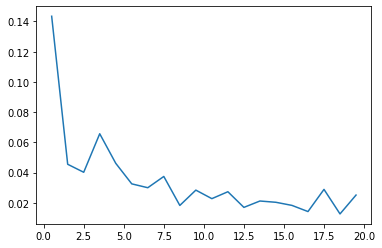

In [177]:
XY20 = XY[XY['x'].values ** 2 + XY['y'].values ** 2 < 20 ** 2]
#y = XY[XY['x'].values ** 2 + XY['y'].values ** 2 < 20 ** 2]['y'].values
print(XY20)
radius = []
Dm_list = []
for r in np.arange(0,20):
    XYRing = XY[XY['x'].values ** 2 + XY['y'].values ** 2 < (r+1) ** 2]
    XYRing = XYRing[XYRing['x'].values ** 2 + XYRing['y'].values ** 2 > r ** 2]
    radius.append(r + 0.5)
    Dm = XYRing['Dm'].values.mean()
    Dm_list.append(Dm)
plt.plot(radius,Dm_list)

    

In [68]:
pi = 3.1415926535897932384626433832795028841971693993751058209749445923
mu = 1
noise_rand = np.random.rand(5) * mu
cos_sum = 0
for noise in noise_rand:
    print(noise)
    cos_sum += m.cos(6 * (pi/6 + noise))
print(1/5 * cos_sum)
    

0.3752549324113289
0.6903091429149798
0.9409317012988536
0.30668014851488523
0.6520225933237844
0.26989790428739163


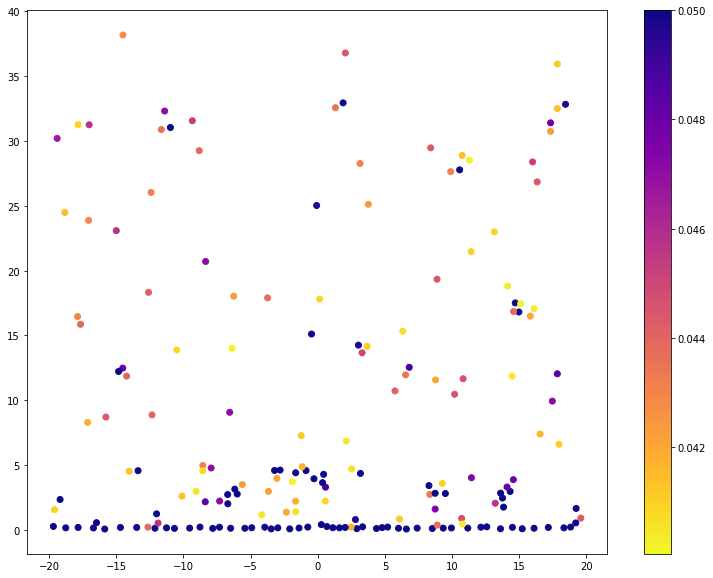

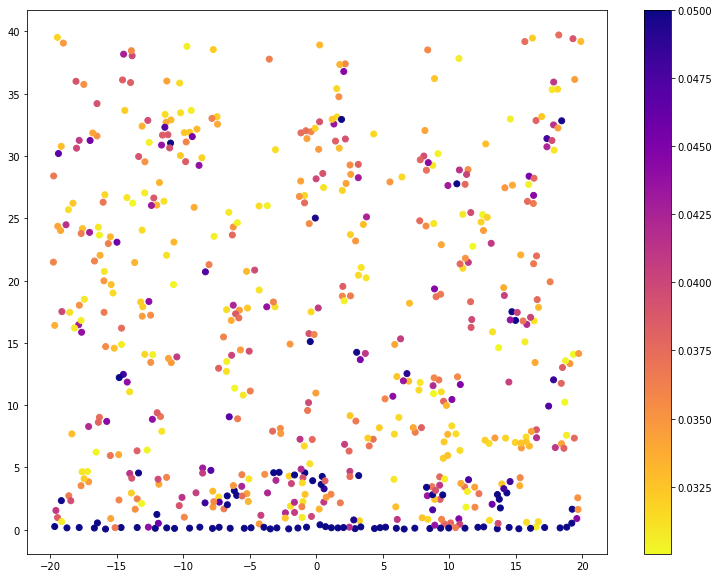

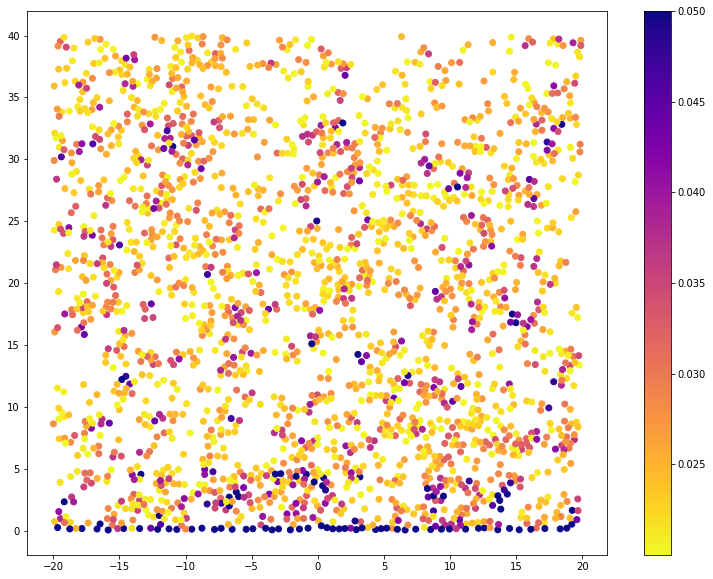

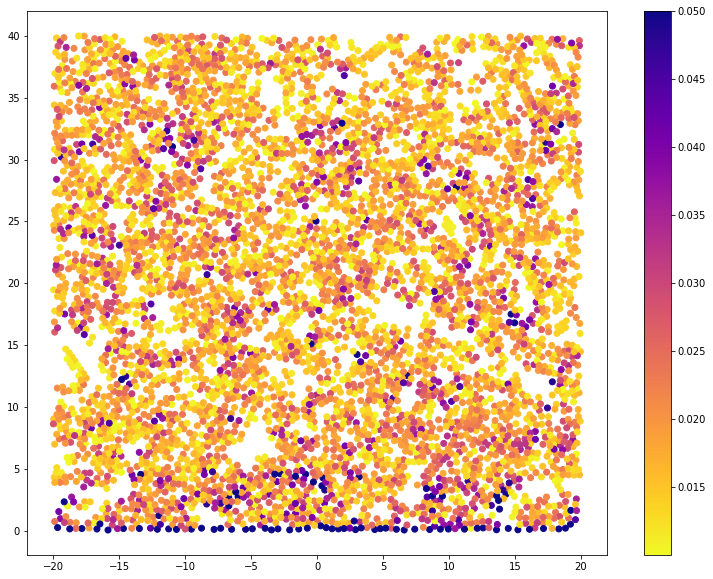

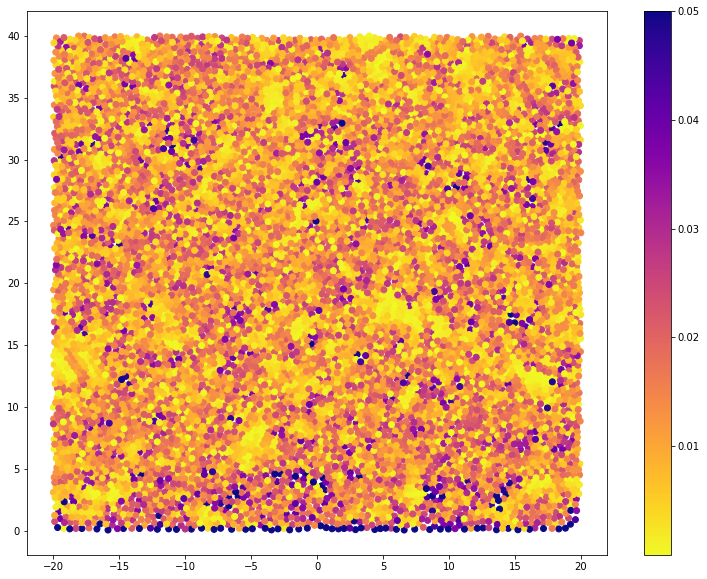

In [50]:
os.system("mkdir " + path + "plots/structure/filtartion")
for filtration in reversed(np.arange(0,0.05,0.01)):
    filtered = gapminder[gapminder['Dm'] > filtration]
    fig, ax = plt.subplots(figsize = (13, 10))

    cm = plt.cm.get_cmap('plasma_r')
    sc = plt.scatter(filtered['x'].values,filtered['y'].values, c = filtered['Dm'].values, cmap=cm,vmax = 0.05)
    fig.colorbar(sc)
    plt.savefig(path + "plots/structure/filtartion/filter" + str(filtration) + ".png")
    plt.show()

In [ ]:
f_score = {spot: float("inf") for row in grid for spot in row}